In [11]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math
from math import sqrt

from scipy.stats import ks_2samp, chi2_contingency, pearsonr, f_oneway
from scipy.stats import ttest_ind
import statsmodels.api as sm

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc,classification_report
from sklearn.metrics import r2_score, precision_recall_fscore_support

#ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.dates as mdates
import calendar
from statsmodels.graphics.tsaplots import month_plot


In [2]:
pd.set_option('display.max_columns', None)

### 1. Time Series EAD

In [3]:
# import dataset

df_company_time_series = pd.read_csv('/Users/diogomonteiro/Documents/Education/CCT/3rd term/ML/CA/CA 2/IT_Company_Time_Series.csv', index_col='Date', parse_dates=True)
df_company_time_series.head()

,Software_1,Software_2,Software_3,Software_4,Software_5,Software_6,Software_7,Software_8,Software_9,Software_10,Software_11,Software_12,Software_13,Software_14,Software_15
Date,,,,,,,,,,,,,,,
2018-01-31,104,97,63,72,50,95,101,63,134,101,72,134,118,95,114
2018-02-28,89,128,61,95,52,97,113,73,144,117,68,110,115,79,131
2018-03-31,114,101,75,85,45,96,120,75,142,109,69,110,117,74,84
2018-04-30,107,94,44,85,35,99,112,75,135,98,59,137,101,72,98
2018-05-31,92,104,66,97,48,81,108,81,138,89,64,124,107,83,122


In [4]:
df_company_time_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2018-01-31 to 2022-12-31
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Software_1   60 non-null     int64
 1   Software_2   60 non-null     int64
 2   Software_3   60 non-null     int64
 3   Software_4   60 non-null     int64
 4   Software_5   60 non-null     int64
 5   Software_6   60 non-null     int64
 6   Software_7   60 non-null     int64
 7   Software_8   60 non-null     int64
 8   Software_9   60 non-null     int64
 9   Software_10  60 non-null     int64
 10  Software_11  60 non-null     int64
 11  Software_12  60 non-null     int64
 12  Software_13  60 non-null     int64
 13  Software_14  60 non-null     int64
 14  Software_15  60 non-null     int64
dtypes: int64(15)
memory usage: 7.5 KB


In [5]:
# Add a new column 'Total'
df_company_time_series['Total'] = df_company_time_series.loc[:,df_company_time_series.columns != 'Year'].sum(axis = 1)
df_company_time_series.head()

,Software_1,Software_2,Software_3,Software_4,Software_5,Software_6,Software_7,Software_8,Software_9,Software_10,Software_11,Software_12,Software_13,Software_14,Software_15,Total
Date,,,,,,,,,,,,,,,,
2018-01-31,104,97,63,72,50,95,101,63,134,101,72,134,118,95,114,1413
2018-02-28,89,128,61,95,52,97,113,73,144,117,68,110,115,79,131,1472
2018-03-31,114,101,75,85,45,96,120,75,142,109,69,110,117,74,84,1416
2018-04-30,107,94,44,85,35,99,112,75,135,98,59,137,101,72,98,1351
2018-05-31,92,104,66,97,48,81,108,81,138,89,64,124,107,83,122,1404


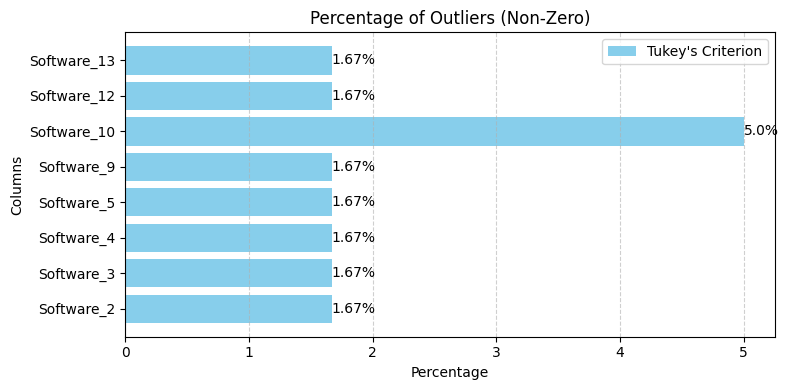

In [6]:
def calculate_percentage_of_outliers(df_company_time_series, column_name, criterion='tukey'):
    # Calculate Interquartile Range
    Q1 = df_company_time_series[column_name].quantile(0.25)
    Q3 = df_company_time_series[column_name].quantile(0.75)
    IQR = Q3 - Q1

    if criterion == 'tukey':
        # Identify outliers using Tukey's criterion
        outliers = ((df_company_time_series[column_name] < (Q1 - 1.5 * IQR)) | (df_company_time_series[column_name] > (Q3 + 1.5 * IQR)))
    else:
        raise ValueError("Unsupported criterion. Use 'tukey'.")

    # Calculate the percentage of outliers
    percentage_of_outliers = round((outliers.sum() / len(df_company_time_series)) * 100, 2)

    return percentage_of_outliers

# Iterate over numerical columns
numerical_columns = df_company_time_series.select_dtypes(include=[np.number]).columns

percentage_outliers_tukey = []
columns_with_outliers = []

for column in numerical_columns:
    percentage_tukey = calculate_percentage_of_outliers(df_company_time_series, column)
    if percentage_tukey != 0:
        percentage_outliers_tukey.append(percentage_tukey)
        columns_with_outliers.append(column)

# Plotting the results for columns with non-zero outlier percentages
plt.figure(figsize=(8, 4))

bars_tukey = plt.barh(np.arange(len(columns_with_outliers)), percentage_outliers_tukey, color='skyblue', label="Tukey's Criterion")

# Add percentage values to the bars
for i, bar in enumerate(bars_tukey):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width()}%', ha='left', va='center', color='black')

plt.yticks(np.arange(len(columns_with_outliers)), columns_with_outliers)
plt.xlabel('Percentage')
plt.ylabel('Columns')
plt.title('Percentage of Outliers (Non-Zero)')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [6]:
# Strip leading and trailing spaces from column headers
df_company_time_series.columns = [col.strip() for col in df_company_time_series.columns]

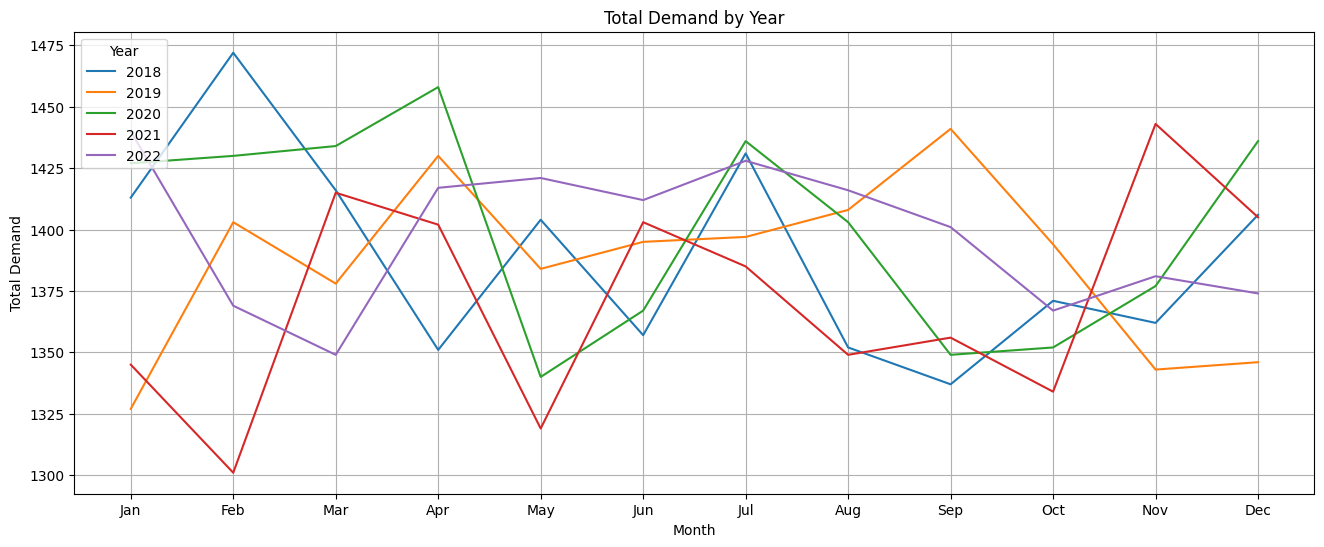

In [8]:

# Group the data by year
yearly_data = df_company_time_series.groupby(df_company_time_series.index.year)

# Plot the data for each year
plt.figure(figsize=(16, 6))
for year, data in yearly_data:
    plt.plot(data.index.month, data['Total'], label=year)

# Customize the x-axis ticks to display month names
plt.xticks(range(1, 13), [calendar.month_abbr[i] for i in range(1, 13)])

# Customize the plot
plt.title('Total Demand by Year')
plt.xlabel('Month')
plt.ylabel('Total Demand')
plt.legend(title='Year', loc='upper left')
plt.grid(True)
plt.show()

In [7]:
# Exploring the dates
df_company_time_series.index

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
      

In [8]:
# by analysing the dates, it should be Monthly but freq=None
# setting up freq = M

df_company_time_series = df_company_time_series.asfreq('M')
df_company_time_series.index

# if there's duplicates dates, this will return an error

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
      

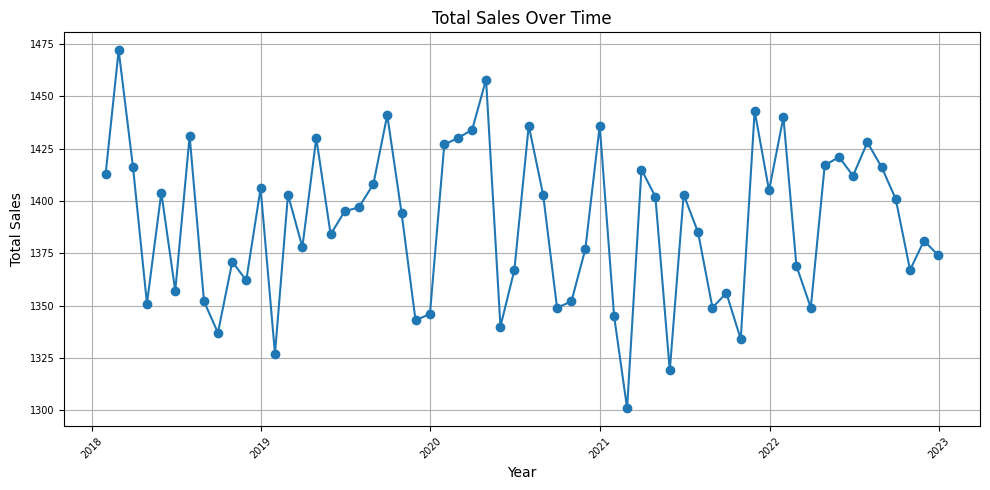

In [11]:
#We visualise the data

plt.figure(figsize=(10, 5))
plt.plot(df_company_time_series.index, df_company_time_series['Total'], marker='o')
plt.xlabel('Year', fontsize=10)
plt.ylabel('Total Sales', fontsize=10)
plt.title('Total Sales Over Time')
plt.grid(True)
plt.xticks(df_company_time_series.index, rotation=45, fontsize=7)
plt.yticks(fontsize=7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display only year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.tight_layout()

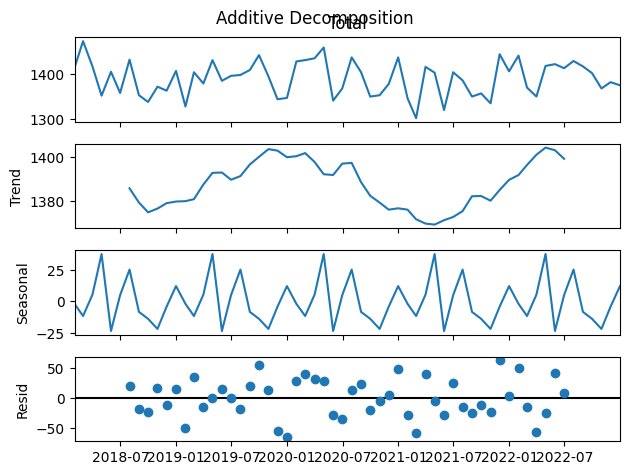

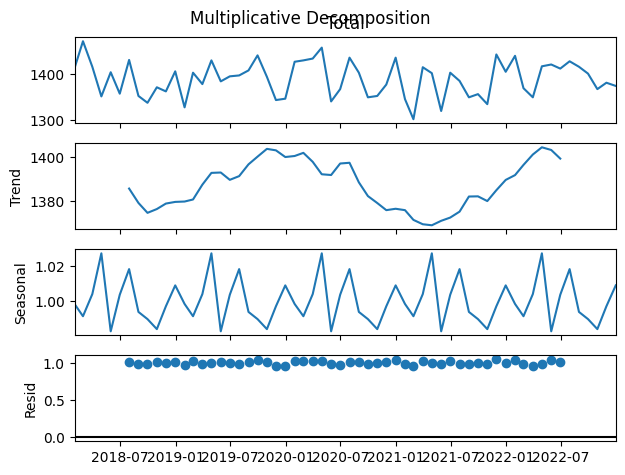

In [147]:

df_company_time_series.index = pd.to_datetime(df_company_time_series.index)
if not df_company_time_series.index.freq:
    df_company_time_series = df_company_time_series.asfreq('M')  # Set to monthly frequency

# Decomposing with explicitly defining the period for monthly data
try:
    # Decomposition with explicit period setting
    # Additive Decomposition
    result_add = seasonal_decompose(df_company_time_series['Total'], model='additive', period=12)
    fig_add = result_add.plot()
    fig_add.suptitle('Additive Decomposition')
    plt.show()

    # Multiplicative Decomposition
    result_mul = seasonal_decompose(df_company_time_series['Total'], model='multiplicative', period=12)
    fig_mul = result_mul.plot()
    fig_mul.suptitle('Multiplicative Decomposition')
    plt.show()
except Exception as e:
    print("Decomposition failed:", e)

In [13]:
# seasonal decomposition --> we use multiplicative approach

In [14]:
decomposition = seasonal_decompose(df_company_time_series['Total'],model = 'multiplicative', period = 12)


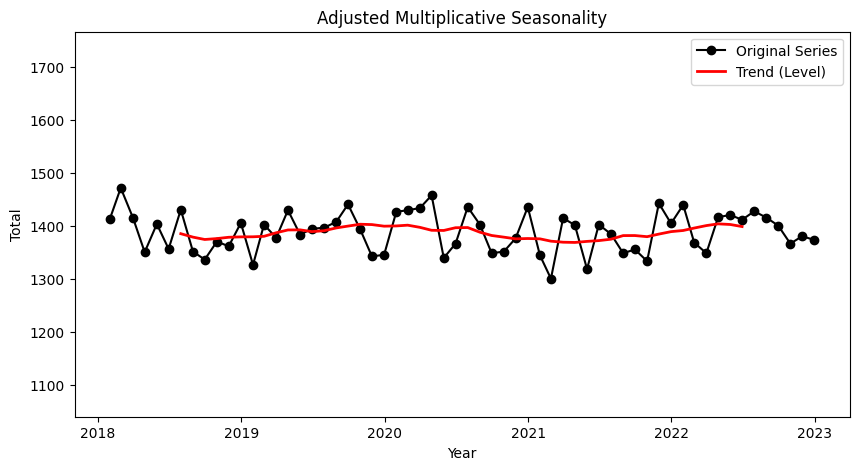

In [15]:
# Decompose the time series
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()
residual = decomposition.resid.dropna()

# Plotting with adjusted bounds
plt.figure(figsize=(10, 5))
plt.plot(df_company_time_series.index, df_company_time_series['Total'], label='Original Series', color='black', marker='o')
plt.plot(trend.index, trend, label='Trend (Level)', color='red', linewidth=2)
plt.title('Adjusted Multiplicative Seasonality')
plt.xlabel('Year')
plt.ylabel('Total')
plt.ylim([min(df_company_time_series['Total'])*0.8, max(df_company_time_series['Total'])*1.2])  # Adjust the y-axis
plt.legend()
plt.show()

#### analyse seasonality per month

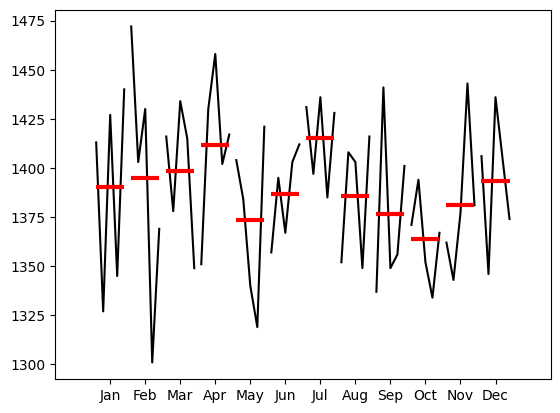

In [16]:
month_plot(df_company_time_series.Total.resample(rule= 'MS').mean())
plt.show()

### 2. Time Series Model

In [30]:
from statsmodels.tsa.stattools import adfuller

#To check the seasonality of the data we need to do a hypothesis test --> Ducky Fuller test

# H0: the data is not stationary
# H1 : the data is stationary

#We conduct the test
result = adfuller(df_company_time_series['Total'])

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpretation based on the p-value
if result[1] < 0.05:
    print('Rejecting the null hypothesis, the data is stationary. ==> Arima.')
else:
    print('Accepting the null hypothesis, the data is non-stationary. ==> Sarimax')


ADF Statistic: -6.312716405221311
p-value: 3.205309121239231e-08
Rejecting the null hypothesis, the data is stationary. ==> Arima.


#### HoltWinters

In [18]:
#As p value is greater than alpha, then we accept the null hypothesis, and then the data is not seasonal

from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(df_company_time_series['Total'],
                            trend = 'multiplicative',
                            seasonal = 'multiplicative',
                            seasonal_periods = 12)

# Fit the model
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=12)

forecast

2023-01-31    1404.008492
2023-02-28    1419.630840
2023-03-31    1412.943791
2023-04-30    1432.660678
2023-05-31    1391.297659
2023-06-30    1401.578522
2023-07-31    1428.145512
2023-08-31    1401.651402
2023-09-30    1390.677739
2023-10-31    1377.423105
2023-11-30    1396.217718
2023-12-31    1413.483047
Freq: ME, dtype: float64

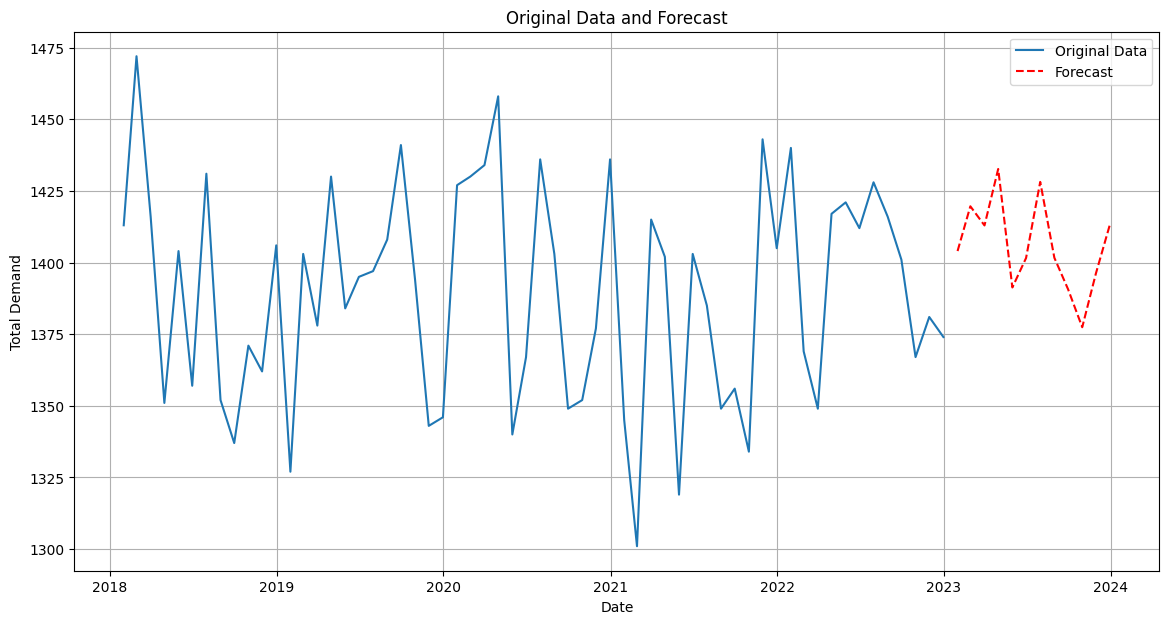

In [19]:
# Step 1: Create the forecast DataFrame
forecast_data = {
    'Date': [
        '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
        '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
        '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'
    ],
    'Forecast': [
        1404.008492, 1419.630840, 1412.943791, 1432.660678,
        1391.297659, 1401.578522, 1428.145512, 1401.651402,
        1390.677739, 1377.423105, 1396.217718, 1413.483047
    ]
}
forecast_df = pd.DataFrame(forecast_data)
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
forecast_df.set_index('Date', inplace=True)

# Step 2: Concatenate with the original dataset
combined_df = pd.concat([df_company_time_series['Total'], forecast_df['Forecast']], axis=0)

# Step 3: Plotting the combined data
plt.figure(figsize=(14, 7))
plt.plot(df_company_time_series['Total'], label='Original Data')
plt.plot(forecast_df['Forecast'], label='Forecast', linestyle='--', color='red')
plt.title('Original Data and Forecast')
plt.xlabel('Date')
plt.ylabel('Total Demand')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Evaluating the model

# Split data into training and validation sets
train_size = int(len(df_company_time_series) * 0.8)
train_data = df_company_time_series.iloc[:train_size]
validation_data = df_company_time_series.iloc[train_size:]

mae = mean_absolute_error(validation_data['Total'], forecast)
mse = mean_squared_error(validation_data['Total'], forecast)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 24.690906435663578
Mean Squared Error (MSE): 949.6129775723056
Root Mean Squared Error (RMSE): 30.815791042455906


In [21]:
df_company_time_series['Total'].mean()

1389.3166666666666

In [22]:
rmse/df_company_time_series['Total'].mean()*100

2.2180537944881227

#### Arima

In [9]:
#Split the data into training and test set

train_data = df_company_time_series[:int(0.8*len(df_company_time_series))]
test_data = df_company_time_series[int(0.8*len(df_company_time_series)):]

In [12]:
#Building the ARIMA model

arima_model = ARIMA(train_data['Total'], order = (1,1,1))
arima_fit = arima_model.fit()

In [13]:
#Forecast for testing set #

arima_forecast = arima_fit.forecast(steps = len(test_data))

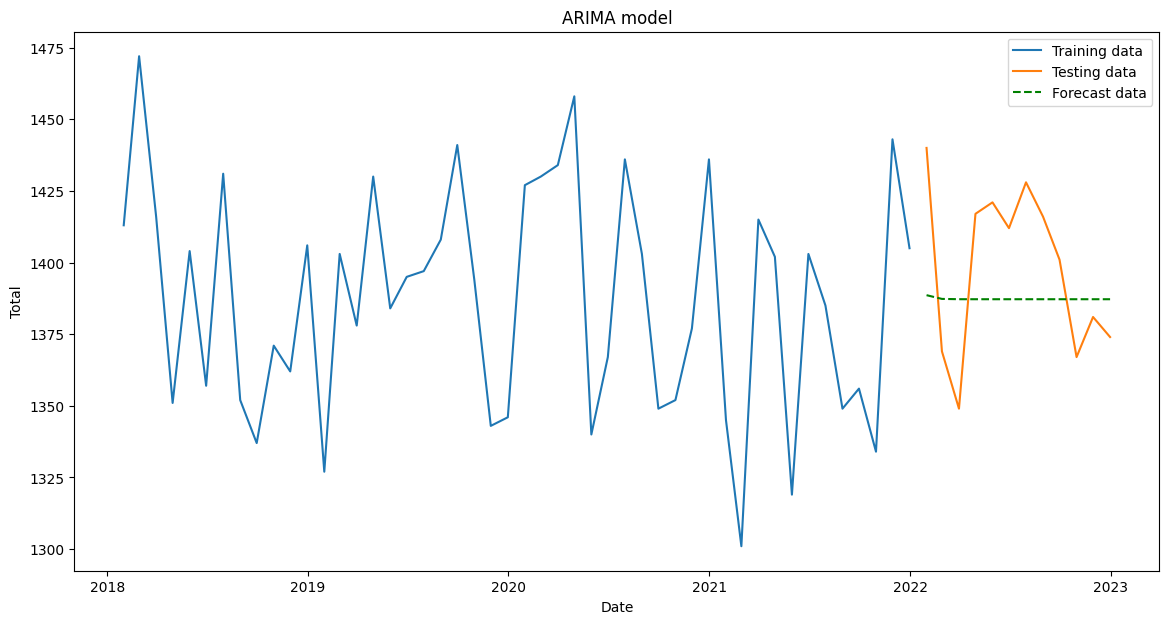

In [27]:
#Visualisation to check the forecasting

plt.figure(figsize = (14,7))
plt.plot(train_data.index, train_data['Total'], label = 'Training data')
plt.plot(test_data.index, test_data['Total'], label = 'Testing data')
plt.plot(test_data.index, arima_forecast, label = 'Forecast data', linestyle='--', color='green')
plt.xlabel('Date')
plt.ylabel('Total')
plt.title('ARIMA model')
plt.legend()
plt.show()

In [34]:
#Now we check what will happen in the next 12 months

forecast_12_steps = 12
future_arima_forecast = arima_fit.get_forecast(steps = forecast_12_steps)
future_arima_df = pd.DataFrame({
    'Forecast': future_arima_forecast.predicted_mean
})
future_arima_df.index = pd.date_range(start = test_data.index[-1] + pd.Timedelta(days=1), periods = forecast_12_steps, freq = 'M')
future_arima_df

,Forecast
2023-01-31,1388.611609
2023-02-28,1387.307331
2023-03-31,1387.203530
2023-04-30,1387.195269
2023-05-31,1387.194611
2023-06-30,1387.194559
2023-07-31,1387.194555
2023-08-31,1387.194554
2023-09-30,1387.194554
2023-10-31,1387.194554


#### SARIMAX

In [17]:
#We just start building the model

sarimax_model = SARIMAX(train_data['Total'],
                       order = (1,1,1),
                       seasonal_order = (1, 1, 1, 12))
sarimax_fit = sarimax_model.fit(disp = False) 

In [18]:
#Forecasting using SARIMAX

sarimax_forecast = sarimax_fit.forecast(steps = len(test_data))

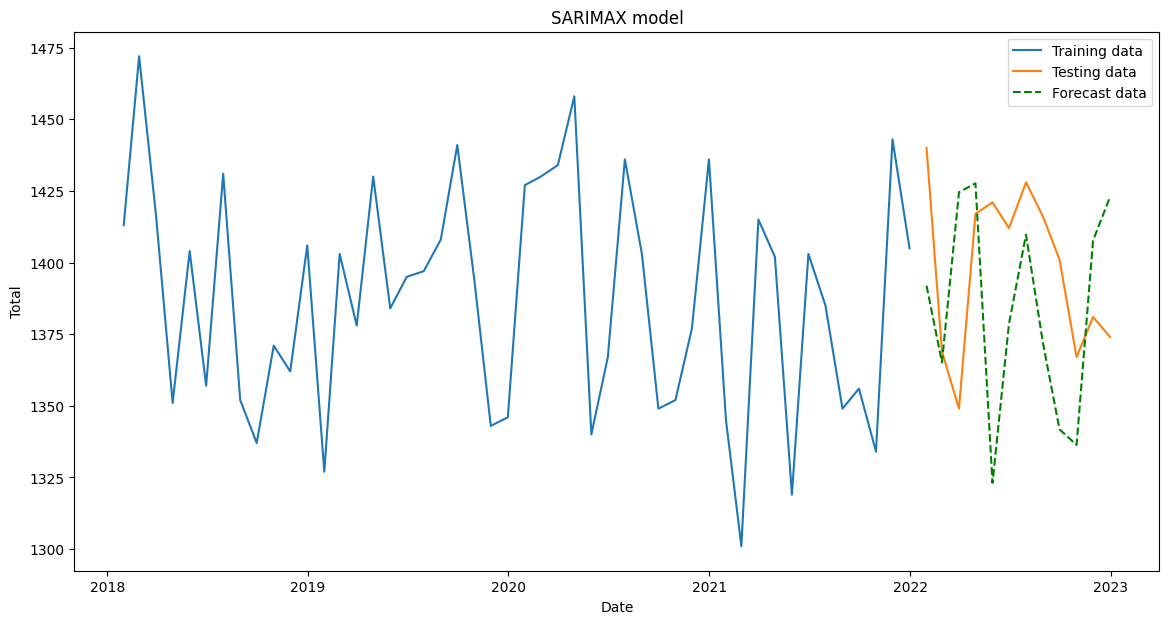

In [26]:
#Visualisation to check the forecasting

plt.figure(figsize = (14,7))
plt.plot(train_data.index, train_data['Total'], label = 'Training data')
plt.plot(test_data.index, test_data['Total'], label = 'Testing data')
plt.plot(test_data.index, sarimax_forecast, label = 'Forecast data', linestyle='--', color='green')
plt.xlabel('Date')
plt.ylabel('Total')
plt.title('SARIMAX model')
plt.legend()
plt.show()

In [32]:
#Now we check what will happen in the next 12 months

forecast_12_steps = 12
future_sarimax_forecast = sarimax_fit.get_forecast(steps = forecast_12_steps)
future_sarimax_df = pd.DataFrame({
    'Forecast': future_sarimax_forecast.predicted_mean
})
future_sarimax_df.index = pd.date_range(start = test_data.index[-1] + pd.Timedelta(days=1), periods = forecast_12_steps, freq = 'M')

future_sarimax_df

,Forecast
2023-01-31,1391.925742
2023-02-28,1365.174296
2023-03-31,1424.537278
2023-04-30,1427.632017
2023-05-31,1323.096123
2023-06-30,1378.593269
2023-07-31,1409.712355
2023-08-31,1371.725919
2023-09-30,1341.788854
2023-10-31,1336.337690


In [22]:
#We calculate the MAPE (error)

#ARIMA

non_zero_test_arima = test_data['Total'] !=0
filtered_test_arima = test_data['Total'][non_zero_test_arima]
filtered_forecast_arima = arima_forecast[non_zero_test_arima]
mape = np.mean(np.abs((filtered_test_arima - filtered_forecast_arima)/filtered_test_arima))*100
mape

1.8950310801495511

In [23]:
#SARIMAX

non_zero_test_sarimax = test_data['Total'] !=0
filtered_test_sarimax = test_data['Total'][non_zero_test_sarimax]
filtered_forecast_sarimax = sarimax_forecast[non_zero_test_sarimax]
mape = np.mean(np.abs((filtered_test_sarimax - filtered_forecast_sarimax)/filtered_test_sarimax))*100
mape

2.966286945088658

#### Identifying the Top Software

In [36]:
# Calculate total demand for each software product
software_demand = df_company_time_series.drop('Total',axis=1).sum()

# Rank software products based on total demand
software_demand_ranked = software_demand.sort_values(ascending=False)

# Select top software products
top_software = software_demand_ranked.head(5)

print("Top Software Products:")
print(top_software)

Top Software Products:
Software_9     7691
Software_12    7365
Software_13    6970
Software_7     6586
Software_15    6260
dtype: int64


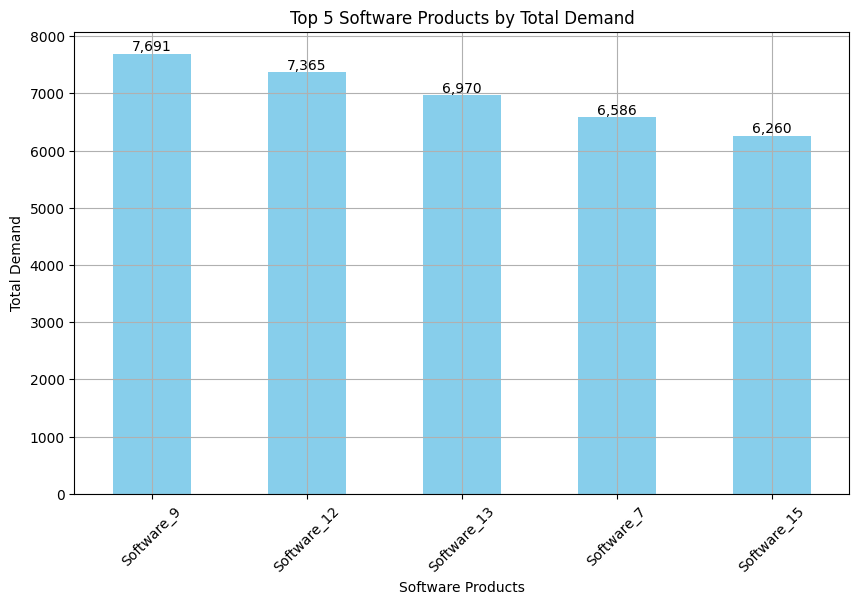

In [45]:
# Plotting
plt.figure(figsize=(10, 6))
ax = top_software.plot(kind='bar', color='skyblue')
plt.title('Top 5 Software Products by Total Demand')
plt.xlabel('Software Products')
plt.ylabel('Total Demand')
plt.xticks(rotation=45)
plt.grid(True)

# Annotating each bar with the value of total demand
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height(), f'{i.get_height():,.0f}', ha='center', va='bottom')

plt.show()

In [41]:
# Define the number of forecast steps (next 12 months)
forecast_steps = 12

# Dictionary to store forecasts for each software product
forecasts = {}

# Iterating over each top software product
for software in top_software.index:
    # Extract demand time series for the current software
    demand_series = df_company_time_series[software]
    
    # Define the SARIMAX model
    # You need to determine the order (p, d, q) and seasonal_order (P, D, Q, s) based on the data characteristics
    model = SARIMAX(demand_series,
                    order=(1, 1, 1),  # Example: (p, d, q)
                    seasonal_order=(1, 1, 1, 12),  # Example: (P, D, Q, s) with 's' = 12 for monthly data
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    
    # Fit the model
    fitted_model = model.fit(disp=False)  # Set 'disp' to False to turn off diagnostic messages
    
    # Forecast demand for the next 12 months
    forecast = fitted_model.get_forecast(steps=forecast_steps)
    predictions = forecast.predicted_mean
    
    # Store the forecast in the dictionary
    forecasts[software] = predictions

# Convert the forecasts dictionary to a DataFrame
forecast_df = pd.DataFrame(forecasts, index=pd.date_range(start=df_company_time_series.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M'))

print("Forecasted Demand for the Next 12 Months:")
forecast_df


Forecasted Demand for the Next 12 Months:


,Software_9,Software_12,Software_13,Software_7,Software_15
2023-01-31,109.741697,-1.546413e+10,120.889691,110.939232,99.606603
2023-02-28,89.284846,-2.222854e+10,127.893823,111.870249,77.838121
2023-03-31,109.564283,-2.842014e+10,126.047125,123.903147,104.529235
2023-04-30,103.581129,-3.408743e+10,109.753010,117.096082,103.508303
2023-05-31,124.378028,-3.927482e+10,107.249611,109.684747,87.803852
2023-06-30,93.594900,-4.402294e+10,131.657651,109.898147,114.184905
2023-07-31,110.440226,-4.836900e+10,119.655683,104.913608,98.617211
2023-08-31,117.292299,-5.234702e+10,132.942304,113.476502,104.156114
2023-09-30,111.426106,-5.598819e+10,114.418310,110.471348,100.468335
2023-10-31,105.482440,-5.932103e+10,108.720577,106.096085,110.643425


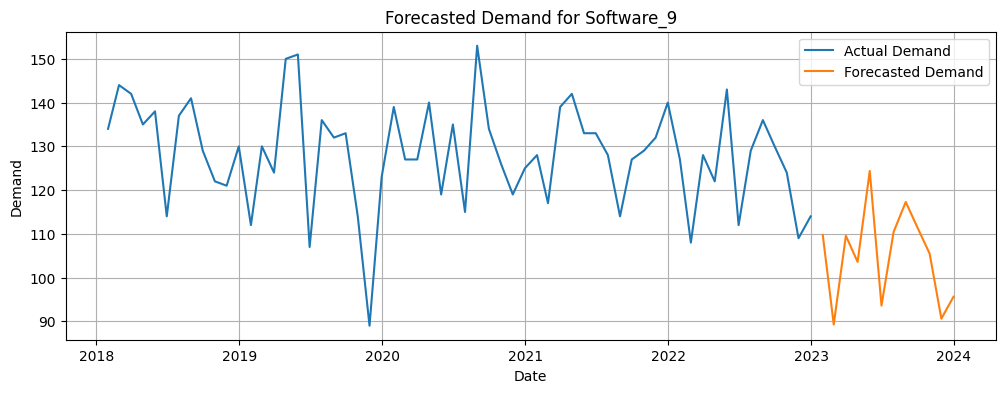

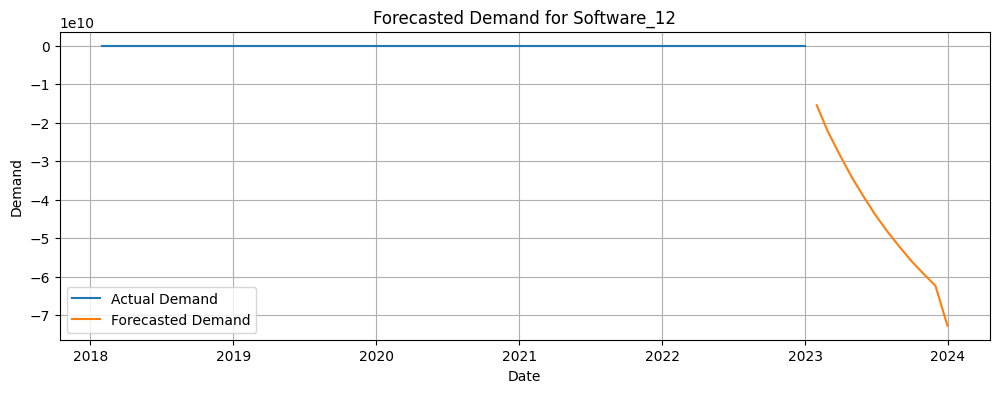

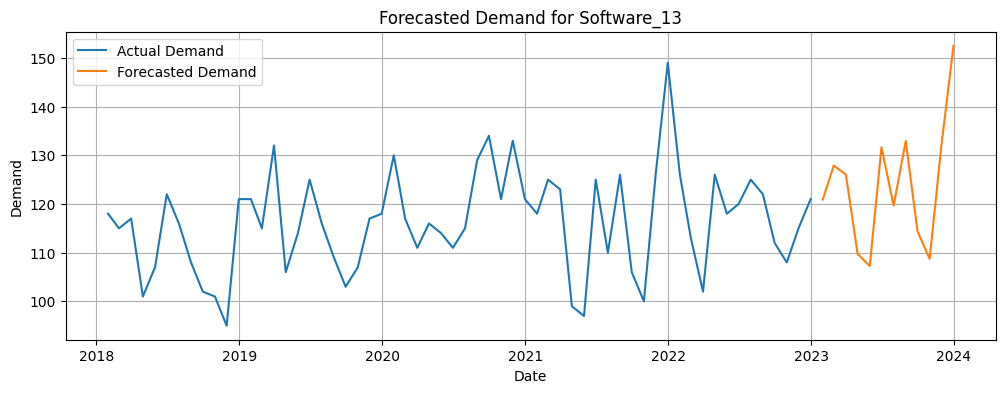

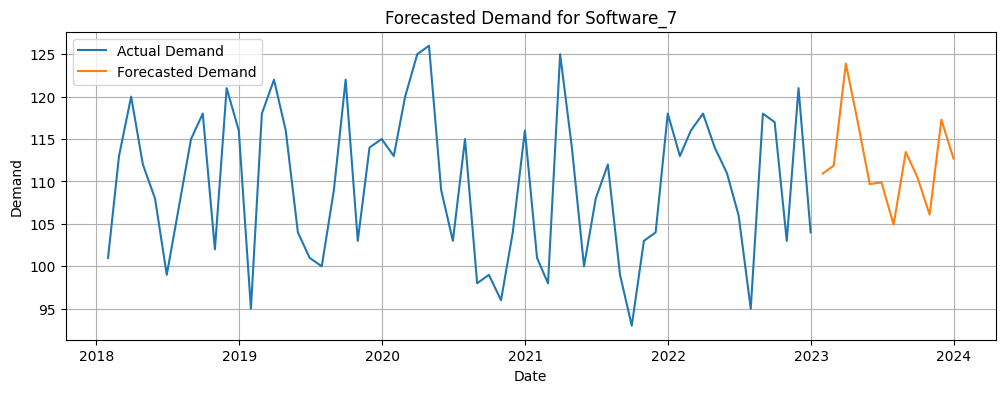

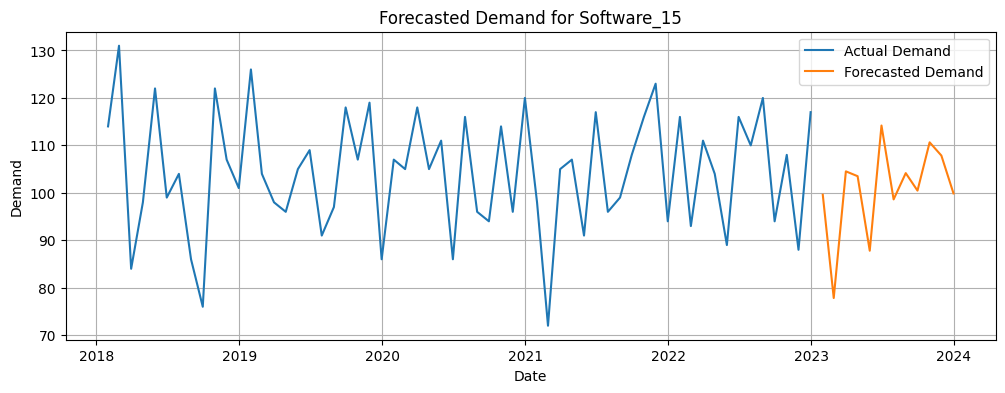

In [38]:
# Plot the forecasted demand for each software product
for software in top_software.index:
    plt.figure(figsize=(12, 4))
    plt.plot(df_company_time_series.index, df_company_time_series[software], label='Actual Demand')
    plt.plot(forecast_df.index, forecast_df[software], label='Forecasted Demand')
    plt.title(f'Forecasted Demand for {software}')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.grid(True)
    plt.show()

### 3. Classification Model for Company_System_Issues_Classification

In [26]:
# import dataset

df_company_system = pd.read_csv('IT_Company_System_Issues_Classification.csv', index_col='Unnamed: 0')
df_company_system.head()

,Issue_ID,Issue_Type,System_Component,Customer_Impact,Time_to_Resolve_hrs,Reported_By,Priority,Previous_Occurrences,Issue_Reported_Month,Resolved
0,8544,Hardware,Component_D,High,43.117583,Automated_System,High,2,Jul,True
1,6569,Server,Component_B,Low,71.695013,Customer,Low,6,May,False
2,3990,Server,Component_D,Medium,31.621253,Automated_System,Medium,4,Mar,False
3,3504,Server,Component_C,Low,66.329435,Automated_System,Medium,0,Sep,True
4,1587,Server,Component_D,Medium,25.168704,Automated_System,Medium,2,Jun,False


In [27]:
df_company_system.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Issue_ID              1000 non-null   int64  
 1   Issue_Type            1000 non-null   object 
 2   System_Component      1000 non-null   object 
 3   Customer_Impact       1000 non-null   object 
 4   Time_to_Resolve_hrs   1000 non-null   float64
 5   Reported_By           1000 non-null   object 
 6   Priority              1000 non-null   object 
 7   Previous_Occurrences  1000 non-null   int64  
 8   Issue_Reported_Month  1000 non-null   object 
 9   Resolved              1000 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 79.1+ KB


In [28]:
df_company_system.isnull().sum()

Issue_ID                0
Issue_Type              0
System_Component        0
Customer_Impact         0
Time_to_Resolve_hrs     0
Reported_By             0
Priority                0
Previous_Occurrences    0
Issue_Reported_Month    0
Resolved                0
dtype: int64

In [29]:
df_company_system.describe()

,Issue_ID,Time_to_Resolve_hrs,Previous_Occurrences
count,1000.000000,1000.000000,1000.000000
mean,5457.773000,35.758472,4.471000
std,2530.039561,20.732766,3.023624
min,1006.000000,0.516233,0.000000
25%,3253.250000,17.931090,2.000000
50%,5415.000000,34.537280,4.000000
75%,7581.500000,53.575284,7.000000
max,9988.000000,71.913695,9.000000


In [30]:
df_company_system['Priority'].value_counts()

Priority
High      255
Medium    255
Low       249
Urgent    241
Name: count, dtype: int64

In [31]:
df_company_system['Issue_Type'].value_counts()

Issue_Type
Software    260
Server      254
Hardware    247
Network     239
Name: count, dtype: int64

In [32]:
df_company_system['Customer_Impact'].value_counts()

Customer_Impact
Low       350
Medium    329
High      321
Name: count, dtype: int64

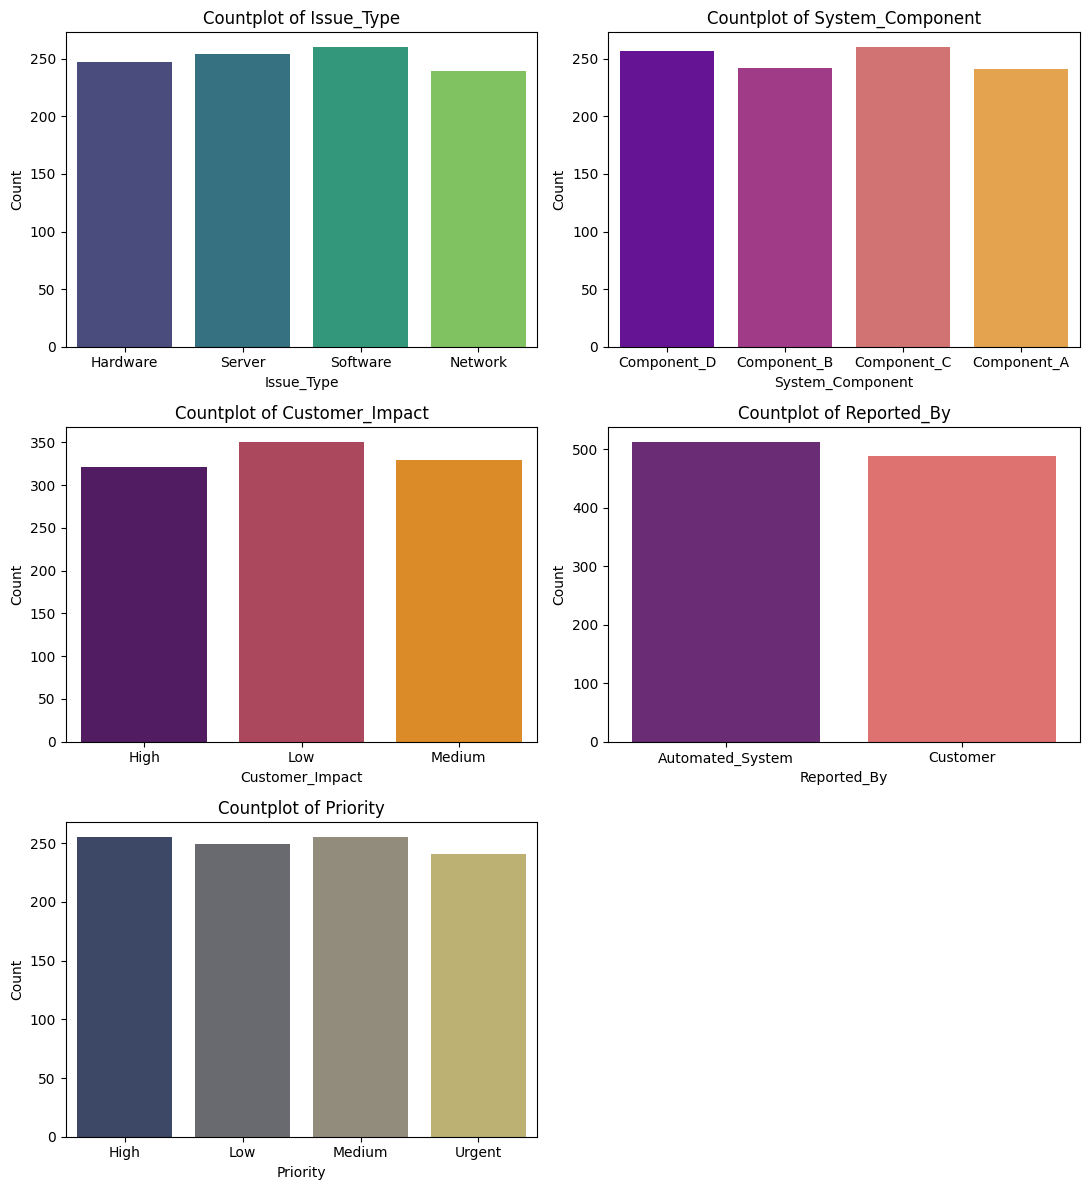

In [33]:
# List of categorical variables
categorical_vars = df_company_system.drop('Issue_Reported_Month', axis=1).select_dtypes(include=['object']).columns.tolist()

# Define a list of palette names
palettes = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

# Calculate the number of rows needed for the subplot grid
num_rows = (len(categorical_vars) + 1) // 2

# Set up the subplot grid
fig, axes = plt.subplots(num_rows, 2, figsize=(11, 4*num_rows))

# Flatten the axes array to iterate over them
axes = axes.flatten()

# Iterate over each categorical variable and create a countplot
for i, (var, palette) in enumerate(zip(categorical_vars, palettes)):
    sns.countplot(x=var, data=df_company_system, ax=axes[i], palette=palette)
    axes[i].set_title(f'Countplot of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

# Remove any unused subplots
for j in range(len(categorical_vars), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [34]:
# Create the pivot table
pivot_table = pd.pivot_table(df_company_system, index='Issue_Type', columns='System_Component', aggfunc='size', fill_value=0)
pivot_table

System_Component,Component_A,Component_B,Component_C,Component_D
Issue_Type,,,,
Hardware,69,63,56,59
Network,63,52,67,57
Server,56,57,69,72
Software,53,70,68,69


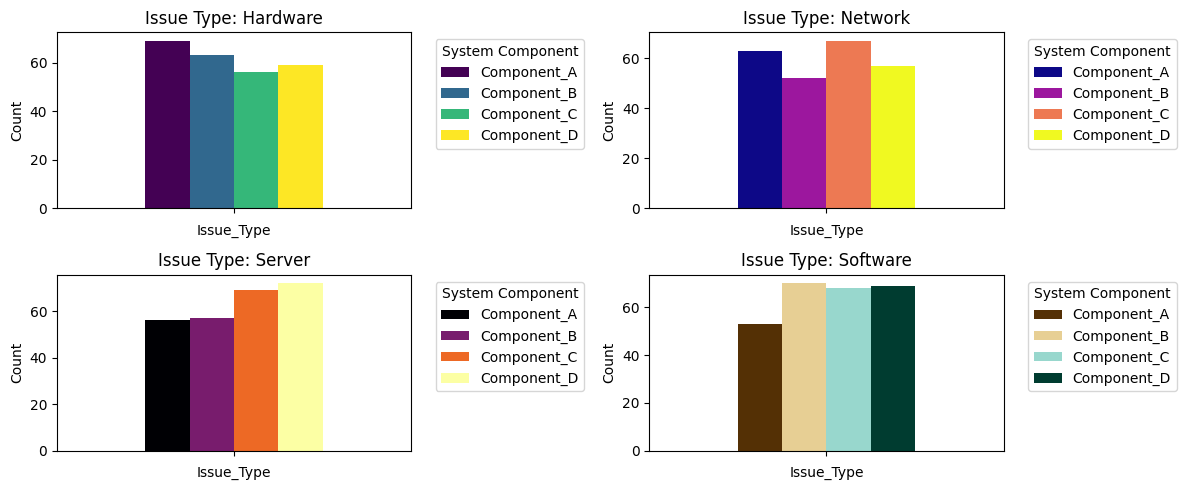

In [35]:
# Get unique issue types
issue_types = pivot_table.index.tolist()

# Get unique system components
components = pivot_table.columns.tolist()

# Define a list of colormaps
colormaps = ['viridis', 'plasma', 'inferno', 'BrBG', 'rainbow']

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 5))

# Flatten the subplot array for easy iteration
axs = axs.flatten()

# Plot each issue type versus component on a separate graph
for i, (issue_type, cmap) in enumerate(zip(issue_types, colormaps)):
    ax = axs[i]
    pivot_table.loc[[issue_type]].plot(kind='bar', ax=ax, cmap=cmap)
    ax.set_title(f'Issue Type: {issue_type}')
    ax.set_ylabel('Count')
    ax.legend(title='System Component', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticklabels([])

plt.tight_layout()
plt.show()


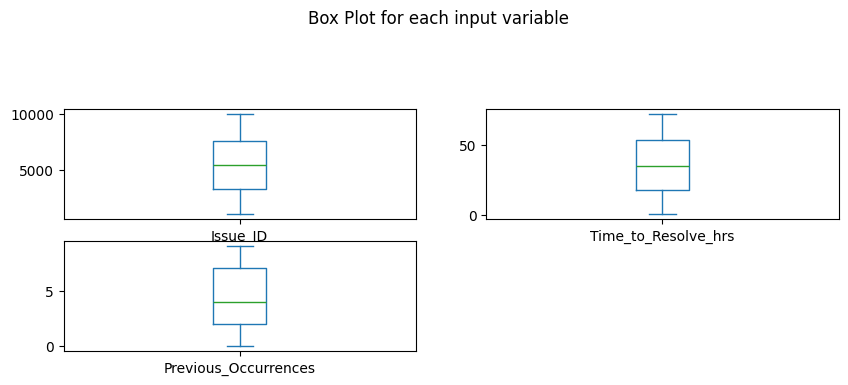

In [36]:
df_company_system.plot(kind='box', subplots=True, layout=(6,2), sharex=False, sharey=False, figsize=(10,10), title='Box Plot for each input variable')
plt.show()

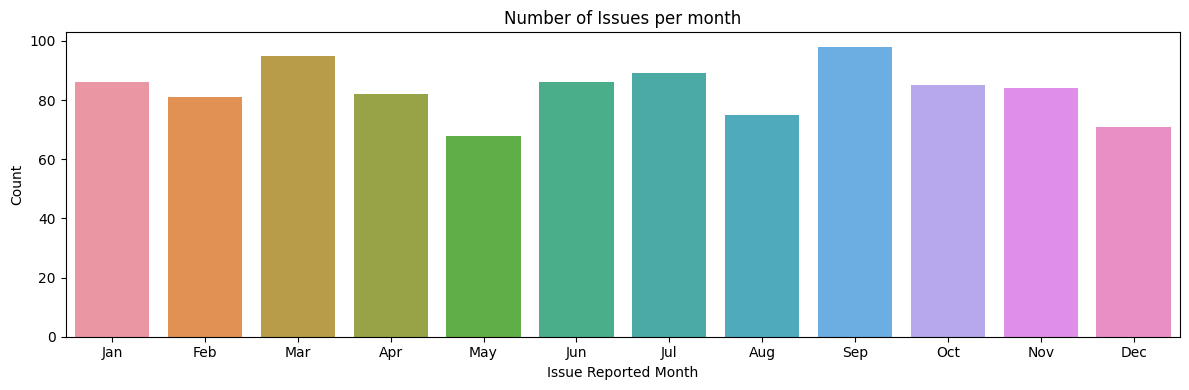

In [37]:
# Get unique months and sort them by month number
months = sorted(df_company_system['Issue_Reported_Month'].unique(), key=lambda x: list(calendar.month_abbr).index(x))

# Set up the subplot grid
fig, ax = plt.subplots(figsize=(12, 4))

# Create countplot organized by month
sns.countplot(x='Issue_Reported_Month', data=df_company_system, order=months, ax=ax)
ax.set_title('Number of Issues per month')
ax.set_xlabel('Issue Reported Month')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [38]:
# Count occurrences of each month
month_counts = df_company_system['Issue_Reported_Month'].value_counts().reindex(months)

# Print or use the counts as needed
print(month_counts)

Issue_Reported_Month
Jan    86
Feb    81
Mar    95
Apr    82
May    68
Jun    86
Jul    89
Aug    75
Sep    98
Oct    85
Nov    84
Dec    71
Name: count, dtype: int64


#### Analysing correlations

In [39]:
# Define the function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Calculate Cramér's V for correlation between 'ABC' and each column
cramers_v_scores = {}
for column in df_company_system.columns:
    if column != 'Priority':  # Skip correlation with 'ABC' itself
        cramers_v_score = cramers_v(df_company_system['Priority'], df_company_system[column])
        cramers_v_scores[column] = cramers_v_score

# Sort the dictionary by Cramér's V score in descending order
sorted_scores = sorted(cramers_v_scores.items(), key=lambda x: x[1], reverse=True)

# Print the sorted columns and their Cramér's V scores
for column, score in sorted_scores:
    print(f"Cramér's V for correlation between 'Priority' and '{column}':", score)
    

Cramér's V for correlation between 'Priority' and 'Issue_Type': 0.04734801738962021
Cramér's V for correlation between 'Priority' and 'Customer_Impact': 0.0
Cramér's V for correlation between 'Priority' and 'Time_to_Resolve_hrs': nan
Cramér's V for correlation between 'Priority' and 'Issue_Reported_Month': 0.030278822972204647
Cramér's V for correlation between 'Priority' and 'Issue_ID': 0.0
Cramér's V for correlation between 'Priority' and 'System_Component': 0.0
Cramér's V for correlation between 'Priority' and 'Reported_By': 0.0
Cramér's V for correlation between 'Priority' and 'Previous_Occurrences': 0.0
Cramér's V for correlation between 'Priority' and 'Resolved': 0.0


In [40]:
df_enc = df_company_system.copy()

In [41]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode System_Component
df_enc['System_Component_enc'] = label_encoder.fit_transform(df_enc['System_Component'])

# Encode Customer_Impact
df_enc['Customer_Impact_enc'] = label_encoder.fit_transform(df_enc['Customer_Impact'])

# Encode Reported_By
df_enc['Reported_By_enc'] = label_encoder.fit_transform(df_enc['Reported_By'])

# Mapping dictionary for Priority to numerical values
priority_mapping = {
    'Low': 4, 'Medium': 3, 'High': 2, 'Urgent': 1
}
# Convert Priority to numerical values
df_enc['Priority_enc'] = df_enc['Priority'].map(priority_mapping)

# Mapping dictionary for month names to numerical values
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Convert month names to numerical values
df_enc['Issue_Reported_Month_enc'] = df_enc['Issue_Reported_Month'].map(month_mapping)

# Encode Resolved (True or False)
df_enc['Resolved_enc'] = label_encoder.fit_transform(df_enc['Resolved'])

In [42]:
# Calculate the quartiles
Q1 = df_enc['Time_to_Resolve_hrs'].quantile(0.25)
Q3 = df_enc['Time_to_Resolve_hrs'].quantile(0.75)

# Calculate the interquartile range
IQR = Q3 - Q1

# Define the bins based on the quartiles
bins = [float('-inf'), Q1, Q3, float('inf')]

# Define labels for the bins
labels = ['Low', 'Medium', 'High']

# Create a new column with the bin categories
df_enc['Time_to_Resolve_Category'] = pd.cut(df_enc['Time_to_Resolve_hrs'], bins=bins, labels=labels)

In [43]:
# Encode Time_to_Resolve_Category
df_enc['Time_to_Resolve_Category_enc'] = label_encoder.fit_transform(df_enc['Time_to_Resolve_Category'])

In [44]:
df_enc.head(20)

,Issue_ID,Issue_Type,System_Component,Customer_Impact,Time_to_Resolve_hrs,Reported_By,Priority,Previous_Occurrences,Issue_Reported_Month,Resolved,System_Component_enc,Customer_Impact_enc,Reported_By_enc,Priority_enc,Issue_Reported_Month_enc,Resolved_enc,Time_to_Resolve_Category,Time_to_Resolve_Category_enc
0,8544,Hardware,Component_D,High,43.117583,Automated_System,High,2,Jul,True,3,0,0,2,7,1,Medium,2
1,6569,Server,Component_B,Low,71.695013,Customer,Low,6,May,False,1,1,1,4,5,0,High,0
2,3990,Server,Component_D,Medium,31.621253,Automated_System,Medium,4,Mar,False,3,2,0,3,3,0,Medium,2
3,3504,Server,Component_C,Low,66.329435,Automated_System,Medium,0,Sep,True,2,1,0,3,9,1,High,0
4,1587,Server,Component_D,Medium,25.168704,Automated_System,Medium,2,Jun,False,3,2,0,3,6,0,Medium,2
5,5079,Software,Component_D,Low,4.413389,Automated_System,High,4,Nov,True,3,1,0,2,11,1,Low,1
6,4348,Software,Component_D,High,15.103311,Customer,Urgent,6,Jan,True,3,0,1,1,1,1,Low,1
7,7299,Software,Component_B,High,30.436703,Customer,Urgent,2,May,True,1,0,1,1,5,1,Medium,2
8,4831,Software,Component_C,Low,16.203897,Customer,High,5,Jul,False,2,1,1,2,7,0,Low,1
9,9381,Network,Component_A,High,0.516233,Automated_System,Medium,4,Apr,True,0,0,0,3,4,1,Low,1


In [45]:
from scipy import stats

# Select only numerical columns
numerical_columns = df_enc.select_dtypes(include='number').columns

# Loop through numerical columns
for column in numerical_columns:
    if column != 'Priority_enc':
        pearson_coef, p_value = stats.pearsonr(df_enc[column], df_enc['Priority_enc'])
        # Interpretation of the results
        print(f'Analysis between {column} and Priority_enc:')
        print(f'Pearson correlation coefficient: {pearson_coef}')
        print(f'P-value: {p_value}')
        
        if abs(pearson_coef) >= 0.7:
            print('Correlation Coefficient: Large relationship')
        elif 0.3 <= abs(pearson_coef) < 0.7:
            print('Correlation Coefficient: Moderate relationship')
        else:
            print('Correlation Coefficient: No significant relationship')
        
        if p_value < 0.001:
            print('P-value: Strong certainty in the result')
        elif p_value < 0.05:
            print('P-value: Moderate certainty in the result')
        elif p_value < 0.1:
            print('P-value: Weak certainty in the result')
        else:
            print('P-value: No certainty in the result')
        
        print('\n')

Analysis between Issue_ID and Priority_enc:
Pearson correlation coefficient: -0.009364906403442997
P-value: 0.7673977651298534
Correlation Coefficient: No significant relationship
P-value: No certainty in the result


Analysis between Time_to_Resolve_hrs and Priority_enc:
Pearson correlation coefficient: -0.040107232365935476
P-value: 0.20507461574442432
Correlation Coefficient: No significant relationship
P-value: No certainty in the result


Analysis between Previous_Occurrences and Priority_enc:
Pearson correlation coefficient: -0.025108848760794715
P-value: 0.42769423692757774
Correlation Coefficient: No significant relationship
P-value: No certainty in the result


Analysis between System_Component_enc and Priority_enc:
Pearson correlation coefficient: -0.047598088898863716
P-value: 0.13254178358226032
Correlation Coefficient: No significant relationship
P-value: No certainty in the result


Analysis between Customer_Impact_enc and Priority_enc:
Pearson correlation coefficient: 0.

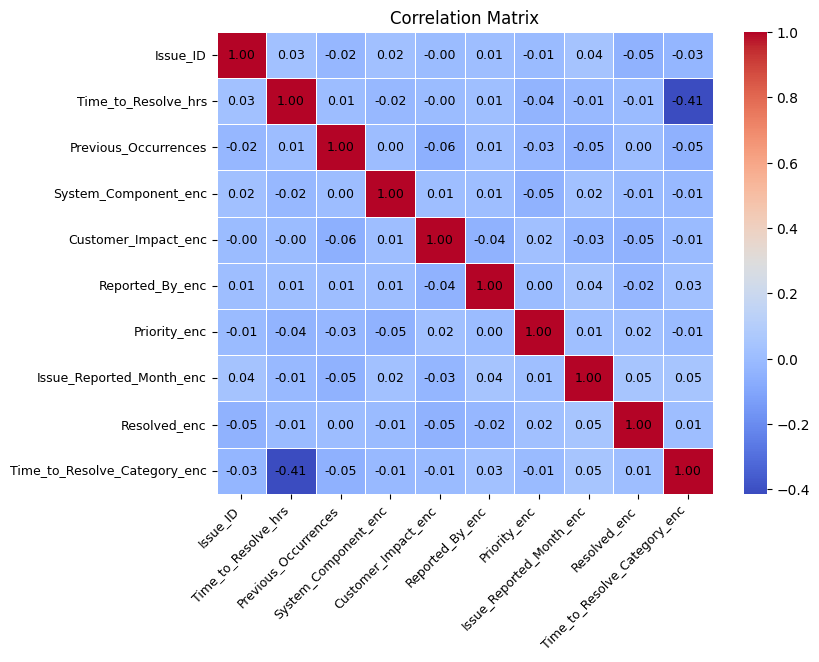

In [46]:
# Select only the numerical columns (excluding 'Record_ID')
numerical_columns = df_enc.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()

# Display the correlation matrix
# print("Correlation Matrix:")
# print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", linewidths=.5)
# Manually annotate the heatmap
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j + 0.5, i + 0.5, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black', fontsize=9)
plt.title("Correlation Matrix")
# Rotate labels on the x-axis and adjust the font size
plt.xticks(rotation=45, ha="right", fontsize = 9)
plt.yticks(ha="right", fontsize = 9)
plt.show()



In [47]:
df_treated = df_enc.drop(columns=['Issue_ID','Issue_Type','System_Component','Reported_By','Priority','Customer_Impact','Issue_Reported_Month','Resolved','Time_to_Resolve_Category'])
df_treated

,Time_to_Resolve_hrs,Previous_Occurrences,System_Component_enc,Customer_Impact_enc,Reported_By_enc,Priority_enc,Issue_Reported_Month_enc,Resolved_enc,Time_to_Resolve_Category_enc
0,43.117583,2,3,0,0,2,7,1,2
1,71.695013,6,1,1,1,4,5,0,0
2,31.621253,4,3,2,0,3,3,0,2
3,66.329435,0,2,1,0,3,9,1,0
4,25.168704,2,3,2,0,3,6,0,2
...,...,...,...,...,...,...,...,...,...
995,69.735378,0,2,2,0,2,3,0,0
996,32.881160,1,3,0,1,3,1,0,2
997,68.118630,7,0,1,1,3,2,0,0
998,48.892633,8,2,2,1,1,5,1,2


In [48]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select the columns to scale
columns_to_scale = ['Time_to_Resolve_hrs']

# Fit the scaler to the selected columns and transform them
scaled_columns = scaler.fit_transform(df_treated[columns_to_scale])

# Create a new DataFrame with the scaled values
scaled_df = pd.DataFrame(scaled_columns, columns=[f"Scaled_{col}" for col in columns_to_scale])

# Concatenate the original DataFrame with the scaled DataFrame
df_treated = pd.concat([df_treated, scaled_df], axis=1)

df_treated

,Time_to_Resolve_hrs,Previous_Occurrences,System_Component_enc,Customer_Impact_enc,Reported_By_enc,Priority_enc,Issue_Reported_Month_enc,Resolved_enc,Time_to_Resolve_Category_enc,Scaled_Time_to_Resolve_hrs
0,43.117583,2,3,0,0,2,7,1,2,0.596679
1,71.695013,6,1,1,1,4,5,0,0,0.996937
2,31.621253,4,3,2,0,3,3,0,2,0.435660
3,66.329435,0,2,1,0,3,9,1,0,0.921786
4,25.168704,2,3,2,0,3,6,0,2,0.345285
...,...,...,...,...,...,...,...,...,...,...
995,69.735378,0,2,2,0,2,3,0,0,0.969490
996,32.881160,1,3,0,1,3,1,0,2,0.453306
997,68.118630,7,0,1,1,3,2,0,0,0.946846
998,48.892633,8,2,2,1,1,5,1,2,0.677565


In [49]:
df_treated = df_treated.drop('Time_to_Resolve_hrs',axis=1)
df_treated.head(1)

,Previous_Occurrences,System_Component_enc,Customer_Impact_enc,Reported_By_enc,Priority_enc,Issue_Reported_Month_enc,Resolved_enc,Time_to_Resolve_Category_enc,Scaled_Time_to_Resolve_hrs
0,2,3,0,0,2,7,1,2,0.596679


In [50]:
df_treated = df_treated.drop('Time_to_Resolve_Category_enc',axis=1)

In [51]:
df_treated = df_treated.rename(columns={
    'System_Component_enc':'System_Component',
    'Customer_Impact_enc':'Customer_Impact',
    'Reported_By_enc':'Reported_By',
    'Priority_enc':'Priority',
    'Issue_Reported_Month_enc':'Issue_Reported_Month',
    'Resolved_enc':'Resolved',
    'Scaled_Time_to_Resolve_hrs':'Time_to_Resolve'
})
df_treated.head(3)

,Previous_Occurrences,System_Component,Customer_Impact,Reported_By,Priority,Issue_Reported_Month,Resolved,Time_to_Resolve
0,2,3,0,0,2,7,1,0.596679
1,6,1,1,1,4,5,0,0.996937
2,4,3,2,0,3,3,0,0.435660


In [52]:
new_order = ['System_Component', 'Customer_Impact', 'Reported_By', 'Issue_Reported_Month', 'Resolved', 'Time_to_Resolve','Priority']

# Reorder the DataFrame
df_treated = df_treated[new_order]
df_treated.head(1)

,System_Component,Customer_Impact,Reported_By,Issue_Reported_Month,Resolved,Time_to_Resolve,Priority
0,3,0,0,7,1,0.596679,2


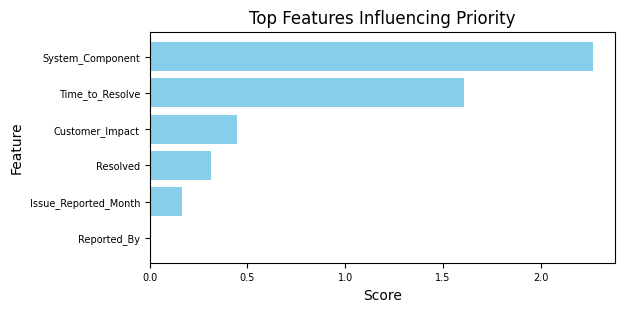

In [53]:
from sklearn.feature_selection import SelectKBest, f_regression

# Initialize SelectKBest
kbest = SelectKBest(score_func=f_regression, k='all') 

# Split your data into features (X) and target variable (y)
X = df_treated.drop(['Priority'], axis=1)  
y = df_treated['Priority']

# Fit SelectKBest on your features and target variable
kbest.fit(X, y)

# Get the scores of each feature
scores = kbest.scores_

# Sort the features based on their scores
sorted_indices = np.argsort(scores)[::-1]  # Sort in descending order

# Plot the top k features with their scores
top_k = 10  # Change this to the number of top features you want to plot
top_features = X.columns[sorted_indices[:top_k]]
top_scores = scores[sorted_indices[:top_k]]

plt.figure(figsize=(6, 3))
plt.barh(top_features, top_scores, color='skyblue')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)
plt.title('Top Features Influencing Priority')
plt.gca().invert_yaxis()
plt.show()

In [54]:
df_treated = df_treated.drop('Reported_By',axis=1)

In [55]:
df_treated.head(1)

,System_Component,Customer_Impact,Issue_Reported_Month,Resolved,Time_to_Resolve,Priority
0,3,0,7,1,0.596679,2


In [56]:
def evaluate_classifiers(models, X_train, y_train, X_test, y_test):
    results = {}
    
    for name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate evaluation metrics
        accuracy = round(accuracy_score(y_test, y_pred), 3)
        precision = round(precision_score(y_test, y_pred, average='weighted'), 3)
        recall = round(recall_score(y_test, y_pred, average='weighted'), 3)
        f1 = round(f1_score(y_test, y_pred, average='weighted'), 3)
        
        results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

    return results

In [57]:
# we select which ones will be X and which will be my y variable
X = df_treated.iloc[:,:-1].values
y = df_treated.iloc[:,-1].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifiers
classifiers = {
    'SVM Classifier': SVC(),
    'RandomForest Classifier': RandomForestClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'KNN Classifier': KNeighborsClassifier(),
    'Naive Bayes Classifier': GaussianNB()
}

# Evaluate the classifiers
results = evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test)

# Convert results dictionary to DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')

results_df

,Accuracy,Precision,Recall,F1 Score
SVM Classifier,0.210,0.149,0.210,0.166
RandomForest Classifier,0.240,0.242,0.240,0.235
Decision Tree Classifier,0.265,0.265,0.265,0.262
KNN Classifier,0.240,0.234,0.240,0.230
Naive Bayes Classifier,0.195,0.148,0.195,0.162


In [58]:
df_company_system = pd.read_csv('IT_Company_System_Issues_Classification.csv', index_col='Unnamed: 0')
df_company_system.head(1)

,Issue_ID,Issue_Type,System_Component,Customer_Impact,Time_to_Resolve_hrs,Reported_By,Priority,Previous_Occurrences,Issue_Reported_Month,Resolved
0,8544,Hardware,Component_D,High,43.117583,Automated_System,High,2,Jul,True


In [59]:
df_test = df_company_system.copy()

In [60]:
# Define a function to map months to seasons
def month_to_season(month):
    spring_months = ['Mar', 'Apr', 'May']
    summer_months = ['Jun', 'Jul', 'Aug']
    autumn_months = ['Sep', 'Oct', 'Nov']
    
    if month in spring_months:
        return 'Spring'
    elif month in summer_months:
        return 'Summer'
    elif month in autumn_months:
        return 'Autumn'
    else:
        return 'Winter'

# Apply the function to create the 'Season' feature
df_test['Season'] = df_test['Issue_Reported_Month'].apply(month_to_season)

In [61]:
df_test.head(1)

,Issue_ID,Issue_Type,System_Component,Customer_Impact,Time_to_Resolve_hrs,Reported_By,Priority,Previous_Occurrences,Issue_Reported_Month,Resolved,Season
0,8544,Hardware,Component_D,High,43.117583,Automated_System,High,2,Jul,True,Summer


In [62]:
# Encode other categorical variables
label_encoder = LabelEncoder()
df_test['Priority_enc'] = label_encoder.fit_transform(df_test['Priority'])

label_encoder = LabelEncoder()
df_test['System_Component_enc'] = label_encoder.fit_transform(df_test['System_Component'])

label_encoder = LabelEncoder()
df_test['Customer_Impact_enc'] = label_encoder.fit_transform(df_test['Customer_Impact'])

label_encoder = LabelEncoder()
df_test['Reported_By_enc'] = label_encoder.fit_transform(df_test['Reported_By'])

label_encoder = LabelEncoder()
df_test['Issue_Type_enc'] = label_encoder.fit_transform(df_test['Issue_Type'])

# Mapping dictionary for month names to numerical values
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Convert month names to numerical values
df_test['Issue_Reported_Month_enc'] = df_test['Issue_Reported_Month'].map(month_mapping)

# Encode 'Resolved' (True or False)
resolved_mapping = {
    'True': 1, 'False': 0
}

df_test['Resolved_enc'] = label_encoder.fit_transform(df_test['Resolved'])
df_test['Time_to_Resolve_days'] = df_test['Time_to_Resolve_hrs'] / 24

# Mapping dictionary for season names to numerical values
season_mapping = {
    'Spring': 1, 'Summer': 2, 'Autumn': 3, 'Winter': 4
}

# Convert season names to numerical values
df_test['Season_enc'] = df_test['Season'].map(season_mapping)

In [63]:
df_test.head(1)

,Issue_ID,Issue_Type,System_Component,Customer_Impact,Time_to_Resolve_hrs,Reported_By,Priority,Previous_Occurrences,Issue_Reported_Month,Resolved,Season,Priority_enc,System_Component_enc,Customer_Impact_enc,Reported_By_enc,Issue_Type_enc,Issue_Reported_Month_enc,Resolved_enc,Time_to_Resolve_days,Season_enc
0,8544,Hardware,Component_D,High,43.117583,Automated_System,High,2,Jul,True,Summer,0,3,0,0,0,7,1,1.796566,2


In [64]:
# Enhanced feature engineering
def enhanced_feature_engineering(df):
    # Extracting temporal features from 'Issue_Reported_Month'
    df['Month_Number'] = df['Issue_Reported_Month'].map({
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    })
    
    # Creating a binary feature for summer
    df['Is_Summer'] = df['Season'].apply(lambda x: 1 if x == 'Summer' else 0)
    
    # Interaction feature: Time to resolve days * Priority_enc
    df['Resolve_Time_Priority_Interaction'] = df['Time_to_Resolve_days'] * df['Priority_enc']
    
    # Drop the original temporal columns
    df = df.drop(columns=['Issue_Reported_Month', 'Season', 'Time_to_Resolve_hrs'])
    
    return df

In [65]:
# Apply the enhanced feature engineering
df_test = enhanced_feature_engineering(df_test)

# Re-encode the categorical variables
df_test['Priority_enc'] = label_encoder.fit_transform(df_test['Priority'])
df_test['Resolved_enc'] = label_encoder.fit_transform(df_test['Resolved'])

# Drop unnecessary columns
df_treated = df_test.drop(columns=['Issue_ID', 'Issue_Type', 'System_Component', 'Customer_Impact', 'Reported_By', 'Priority','Resolved'])
df_treated.head(1)

,Previous_Occurrences,Priority_enc,System_Component_enc,Customer_Impact_enc,Reported_By_enc,Issue_Type_enc,Issue_Reported_Month_enc,Resolved_enc,Time_to_Resolve_days,Season_enc,Month_Number,Is_Summer,Resolve_Time_Priority_Interaction
0,2,0,3,0,0,0,7,1,1.796566,2,7,1,0.0


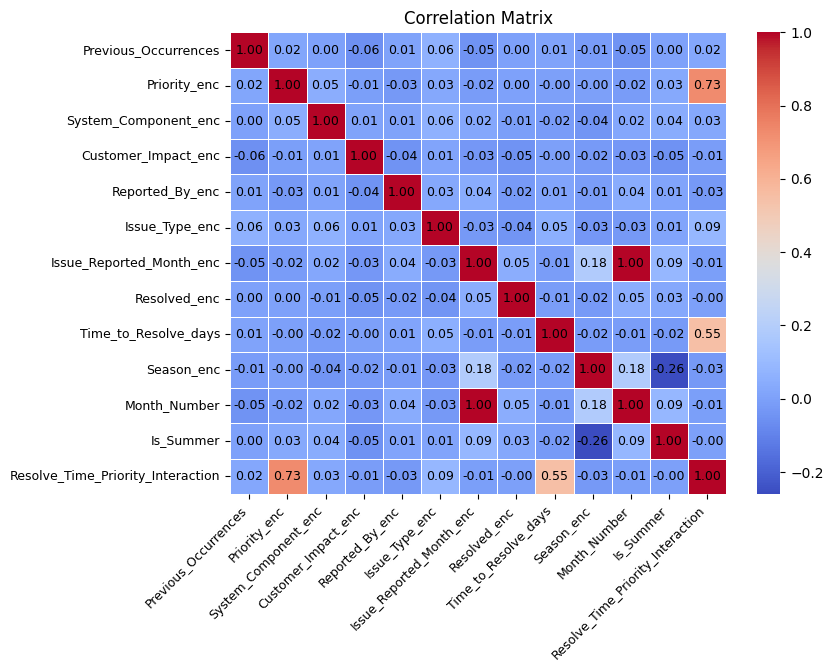

In [66]:
# Select only the numerical columns (excluding 'Record_ID')
numerical_columns = df_treated.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()

# Display the correlation matrix
# print("Correlation Matrix:")
# print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", linewidths=.5)
# Manually annotate the heatmap
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j + 0.5, i + 0.5, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black', fontsize=9)
plt.title("Correlation Matrix")
# Rotate labels on the x-axis and adjust the font size
plt.xticks(rotation=45, ha="right", fontsize = 9)
plt.yticks(ha="right", fontsize = 9)
plt.show()



In [67]:
# Define feature matrix X and target vector y
X = df_treated.drop(columns=['Priority_enc'])
y = df_treated['Priority_enc']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [68]:
# Initialize classifiers

classifiers = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate classifiers
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

results_df = pd.DataFrame(results)
results_df

,SVM,Random Forest,Decision Tree,KNN,Naive Bayes
Accuracy,0.712000,0.820000,0.940000,0.548000,0.648000
Precision,0.732506,0.821917,0.940452,0.553917,0.658276
Recall,0.712000,0.820000,0.940000,0.548000,0.648000
F1 Score,0.698006,0.819506,0.940138,0.543495,0.642464


In [69]:
# feature scaling

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [70]:
# prepare and train the DT Classifier model

classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

Text(0.5, 1.0, 'Confusion Matrix')

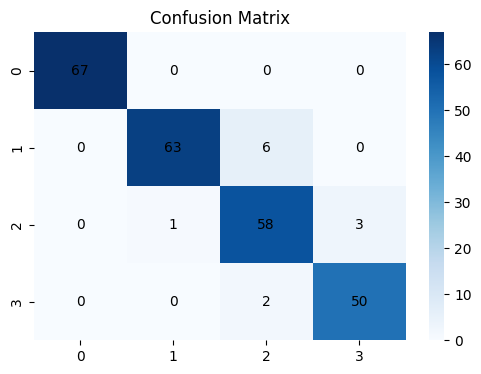

In [71]:
# compare and test results of y

y_pred = classifier.predict(X_test)

# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

# visualize the confusion matrix

plt.figure(figsize=(6,4))
sns.heatmap(cm, fmt = 'd', cmap = 'Blues')
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j+0.5, i+0.5, cm[i, j], ha='center', va='center', color='black', fontsize=10)
plt.title('Confusion Matrix')

In [72]:
cm

array([[67,  0,  0,  0],
       [ 0, 63,  6,  0],
       [ 0,  1, 58,  3],
       [ 0,  0,  2, 50]])

In [73]:
# Evaluating accuracy

accuracy_score(y_test, y_pred)

0.952

In [74]:
# Convert X_test to DataFrame for sampling
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Initialize and train the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Select 10 random tickets from the test set
random_tickets = X_test_df.sample(n=20, random_state=42)
random_ticket_indices = random_tickets.index

# Predict the priority for these 10 random tickets
predictions = dt_classifier.predict(random_tickets)

# Ensure all possible classes are included in label encoding
label_encoder.fit(df_company_system['Priority'])

# Map predictions back to original labels
predicted_priorities = label_encoder.inverse_transform(predictions)

# Display the results
results = random_tickets.copy()
results['Predicted_Priority'] = predicted_priorities
results

,Previous_Occurrences,System_Component_enc,Customer_Impact_enc,Reported_By_enc,Issue_Type_enc,Issue_Reported_Month_enc,Resolved_enc,Time_to_Resolve_days,Season_enc,Month_Number,Is_Summer,Resolve_Time_Priority_Interaction,Predicted_Priority
142,-1.518046,-1.413784,-1.265347,1.016130,0.415963,1.037965,0.978889,0.679975,0.456392,1.037965,-0.576324,1.707934,Urgent
6,0.819122,0.406539,-1.265347,-0.984126,1.309867,-0.126979,0.978889,1.739300,-0.446758,-0.126979,1.735135,2.868135,Urgent
97,-1.184165,1.316700,-0.010042,1.016130,1.309867,0.455493,0.978889,0.164806,-0.446758,0.455493,1.735135,-0.970919,High
60,-0.850284,-0.503623,-0.010042,1.016130,1.309867,0.746729,-1.021566,0.742815,0.456392,0.746729,-0.576324,0.860866,Medium
112,1.153003,-1.413784,-0.010042,1.016130,-0.477940,-0.126979,-1.021566,-1.273461,-0.446758,-0.126979,1.735135,-0.970919,High
181,-1.184165,0.406539,1.245262,-0.984126,-1.371844,1.037965,0.978889,-0.685736,0.456392,1.037965,-0.576324,-0.970919,High
197,1.486884,0.406539,1.245262,-0.984126,-0.477940,-1.583158,-1.021566,-0.543801,1.359542,-1.583158,-0.576324,-0.078558,Medium
184,1.486884,1.316700,1.245262,-0.984126,1.309867,0.455493,-1.021566,-0.811413,-0.446758,0.455493,1.735135,0.074526,Urgent
9,-1.184165,-1.413784,-1.265347,-0.984126,1.309867,-1.000686,0.978889,1.671297,-1.349908,-1.000686,-0.576324,2.793656,Urgent
104,-1.184165,-1.413784,1.245262,1.016130,-0.477940,0.746729,-1.021566,0.360938,0.456392,0.746729,-0.576324,1.358517,Urgent


In [75]:
# Print the first few rows of results to inspect its content
print(results.head())

# Print random_ticket_indices to inspect the indices
print(random_ticket_indices)

# Ensure 'Predicted_Priority' exists in results
print('Predicted_Priority' in results.columns)

# Ensure random_ticket_indices are within the valid range for results
print(all(idx in results.index for idx in random_ticket_indices))


     Previous_Occurrences  System_Component_enc  Customer_Impact_enc  \
142             -1.518046             -1.413784            -1.265347   
6                0.819122              0.406539            -1.265347   
97              -1.184165              1.316700            -0.010042   
60              -0.850284             -0.503623            -0.010042   
112              1.153003             -1.413784            -0.010042   

     Reported_By_enc  Issue_Type_enc  Issue_Reported_Month_enc  Resolved_enc  \
142         1.016130        0.415963                  1.037965      0.978889   
6          -0.984126        1.309867                 -0.126979      0.978889   
97          1.016130        1.309867                  0.455493      0.978889   
60          1.016130        1.309867                  0.746729     -1.021566   
112         1.016130       -0.477940                 -0.126979     -1.021566   

     Time_to_Resolve_days  Season_enc  Month_Number  Is_Summer  \
142              0.6

In [76]:
# Assuming df_treated is your original dataset
indices_to_filter = [142, 6, 97, 60, 112, 181, 197, 184, 9, 104, 200, 216, 236, 240, 67, 224, 194, 15, 177, 24]

filtered_df = df_company_system.loc[indices_to_filter]
filtered_df

,Issue_ID,Issue_Type,System_Component,Customer_Impact,Time_to_Resolve_hrs,Reported_By,Priority,Previous_Occurrences,Issue_Reported_Month,Resolved
142,5378,Server,Component_C,Medium,66.111780,Automated_System,High,9,Feb,False
6,4348,Software,Component_D,High,15.103311,Customer,Urgent,6,Jan,True
97,6717,Software,Component_D,High,37.092303,Automated_System,Low,6,Feb,False
60,5596,Hardware,Component_D,High,0.542753,Automated_System,Low,2,Feb,False
112,8368,Software,Component_C,Medium,22.687056,Customer,High,8,May,False
181,4629,Network,Component_A,High,21.805372,Automated_System,Low,9,May,False
197,4760,Hardware,Component_B,Low,14.475247,Automated_System,Urgent,4,May,False
184,7132,Network,Component_C,Medium,0.932364,Automated_System,Low,8,Nov,True
9,9381,Network,Component_A,High,0.516233,Automated_System,Medium,4,Apr,True
104,6154,Software,Component_B,Low,20.819177,Customer,Low,0,Sep,False


In [77]:
# Indices to filter
indices_to_filter = [142, 6, 97, 60, 112, 181, 197, 184, 9, 104, 200, 216, 236, 240, 67, 224, 194, 15, 177, 24]

# Extract original priorities from df_company_system
original_priorities = df_company_system.loc[indices_to_filter, 'Priority'].reset_index(drop=True)

# Extract predicted priorities from results
predicted_priorities = results.loc[indices_to_filter, 'Predicted_Priority'].reset_index(drop=True)

# Create a new DataFrame combining original and predicted priorities
comparison_df = pd.DataFrame({
    'Original_Priority': original_priorities,
    'Predicted_Priority': predicted_priorities
})

# Display the new DataFrame
comparison_df

,Original_Priority,Predicted_Priority
0,High,Urgent
1,Urgent,Urgent
2,Low,High
3,Low,Medium
4,High,High
5,Low,High
6,Urgent,Medium
7,Low,Urgent
8,Medium,Urgent
9,Low,Urgent


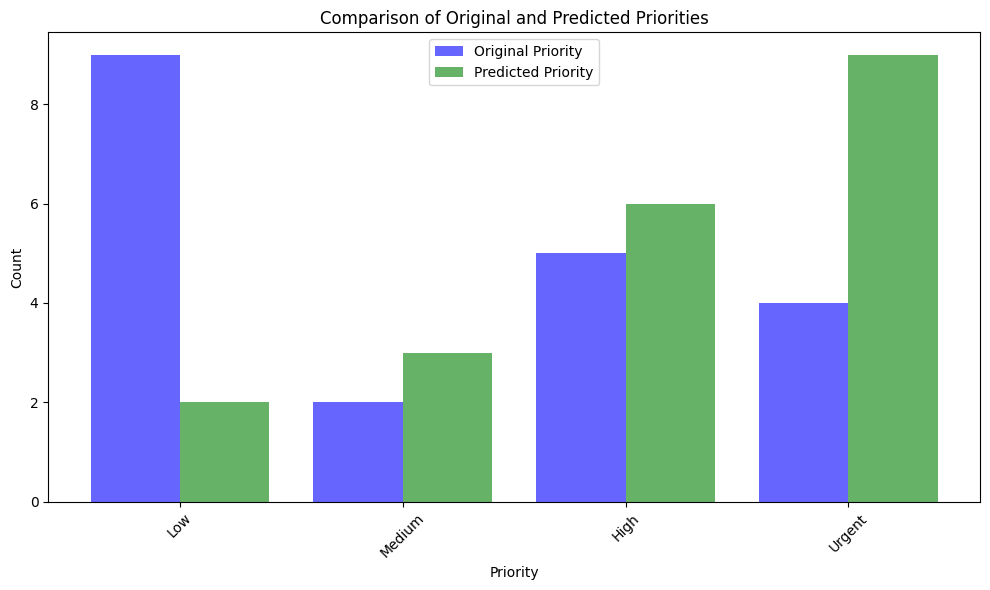

In [78]:
# Count occurrences of each priority category in comparison_df
original_counts = comparison_df['Original_Priority'].value_counts().reindex(['Low', 'Medium', 'High', 'Urgent']).fillna(0)
predicted_counts = comparison_df['Predicted_Priority'].value_counts().reindex(['Low', 'Medium', 'High', 'Urgent']).fillna(0)

# Plotting side-by-side barplot
plt.figure(figsize=(10, 6))

# Define bar width and positions
bar_width = 0.4
index = np.arange(len(original_counts))

# Plotting original priorities
plt.bar(index - bar_width/2, original_counts, bar_width, color='b', alpha=0.6, label='Original Priority')

# Plotting predicted priorities
plt.bar(index + bar_width/2, predicted_counts, bar_width, color='g', alpha=0.6, label='Predicted Priority')

plt.title('Comparison of Original and Predicted Priorities')
plt.xlabel('Priority')
plt.ylabel('Count')
plt.legend()
plt.xticks(index, original_counts.index)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [79]:
results['Predicted_Priority'].value_counts()

Predicted_Priority
Urgent    9
High      6
Medium    3
Low       2
Name: count, dtype: int64

### 4. Anomaly Detection

In [80]:
df_company_system

,Issue_ID,Issue_Type,System_Component,Customer_Impact,Time_to_Resolve_hrs,Reported_By,Priority,Previous_Occurrences,Issue_Reported_Month,Resolved
0,8544,Hardware,Component_D,High,43.117583,Automated_System,High,2,Jul,True
1,6569,Server,Component_B,Low,71.695013,Customer,Low,6,May,False
2,3990,Server,Component_D,Medium,31.621253,Automated_System,Medium,4,Mar,False
3,3504,Server,Component_C,Low,66.329435,Automated_System,Medium,0,Sep,True
4,1587,Server,Component_D,Medium,25.168704,Automated_System,Medium,2,Jun,False
...,...,...,...,...,...,...,...,...,...,...
995,8162,Network,Component_C,Medium,69.735378,Automated_System,High,0,Mar,False
996,7241,Hardware,Component_D,High,32.881160,Customer,Medium,1,Jan,False
997,9399,Server,Component_A,Low,68.118630,Customer,Medium,7,Feb,False
998,6633,Server,Component_C,Medium,48.892633,Customer,Urgent,8,May,True


In [81]:
df_company_system.shape

(1000, 10)

In [82]:
# we select the variables that are relevant to detect anomalies

X_anomaly = df_company_system[['Previous_Occurrences','Time_to_Resolve_hrs']]

In [83]:
from sklearn.ensemble import IsolationForest
# we train the model without specific contamination level

anomaly_detector = IsolationForest(random_state = 0)

In [84]:
# Fit/Train the model
anomaly_detector.fit(X_anomaly)

IsolationForest(random_state=0)

In [85]:
# we can get the scores

anomaly_scores = anomaly_detector.decision_function(X_anomaly)
df_company_system['Anomaly_score'] = anomaly_scores

In [86]:
# we set the anomaly standard, we set a threshold for the scores 2 standard deviation

threshold = anomaly_scores.mean() - 2 * anomaly_scores.std()

In [87]:
# predict the anomalies

df_company_system['Anomaly_threshold'] = df_company_system['Anomaly_score'] < threshold

In [88]:
# display the results --> when we see a -1, there is an anomaly, if 1 there is no anomaly

anomaly_results_score = df_company_system[df_company_system['Anomaly_threshold'] == True]
anomaly_results_score

,Issue_ID,Issue_Type,System_Component,Customer_Impact,Time_to_Resolve_hrs,Reported_By,Priority,Previous_Occurrences,Issue_Reported_Month,Resolved,Anomaly_score,Anomaly_threshold
1,6569,Server,Component_B,Low,71.695013,Customer,Low,6,May,False,-0.110301,True
27,7344,Software,Component_C,High,71.594617,Automated_System,Urgent,7,Jun,True,-0.117389,True
40,1948,Software,Component_D,High,1.208615,Customer,Low,8,Sep,True,-0.103965,True
45,5646,Network,Component_C,High,71.063060,Automated_System,Medium,9,Oct,True,-0.132830,True
49,2138,Server,Component_D,High,71.437698,Automated_System,Medium,6,Jul,True,-0.108651,True
60,5596,Hardware,Component_D,High,0.542753,Automated_System,Low,2,Feb,False,-0.119681,True
91,1040,Server,Component_D,High,68.814546,Automated_System,High,9,Sep,True,-0.099287,True
124,8986,Software,Component_D,Medium,68.828937,Automated_System,Medium,0,Jun,True,-0.117161,True
134,3394,Software,Component_C,Low,70.659917,Automated_System,Medium,9,May,False,-0.128138,True
184,7132,Network,Component_C,Medium,0.932364,Automated_System,Low,8,Nov,True,-0.116867,True


In [89]:
anomaly_results_score.shape

(41, 12)

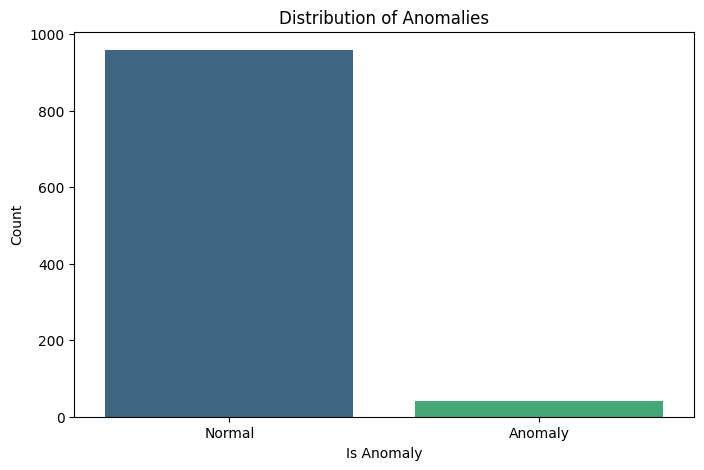

In [90]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Anomaly_threshold', data=df_company_system, palette='viridis')
plt.title('Distribution of Anomalies')
plt.xlabel('Is Anomaly')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.show()

### 5. Recommendation System

In [91]:
# import dataset

df_retail_list = pd.read_csv('IT_Retail_List.csv')#, index_col='Date')
df_retail_list.head()

,InvoiceNo,ItemCode,Most popular item of the day,Quantity,Date,UnitPrice,CustomerID
0,1.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,01/12/2018,2.55,43009.0
1,2.0,71053,WHITE METAL LANTERN,6.0,02/12/2018,3.39,79874.0
2,3.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,03/12/2018,2.75,45061.0
3,4.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,04/12/2018,3.39,47110.0
4,5.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,05/12/2018,3.39,77834.0


In [92]:
df_retail_list.tail()

,InvoiceNo,ItemCode,Most popular item of the day,Quantity,Date,UnitPrice,CustomerID
1623,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1624,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1627,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
df_retail_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628 entries, 0 to 1627
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   InvoiceNo                     1000 non-null   float64
 1   ItemCode                      1000 non-null   object 
 2   Most popular item of the day  999 non-null    object 
 3   Quantity                      1000 non-null   float64
 4   Date                          1000 non-null   object 
 5   UnitPrice                     1000 non-null   float64
 6   CustomerID                    1000 non-null   float64
dtypes: float64(4), object(3)
memory usage: 89.2+ KB


In [94]:
len(df_retail_list['ItemCode'].unique())

591

In [95]:
df_retail_list['CustomerID'].unique()

array([43009., 79874., 45061., 47110., 77834., 55306., 32781., 61453.,
       90129., 67602., 98324., 24599., 88088., 57369., 63514., 75806.,
       43040., 96291., 84004., 71718., 51240., 34860., 43053., 45103.,
       38961., 20530., 65586., 77876., 53303., 30777., 12345., 77881.,
       28730., 81981., 92222., 32827., 53312., 30787., 34883., 34886.,
       73799., 55367., 65610., 77899., 22603., 34894., 38994., 34900.,
       84055., 92249., 94300., 28765., 43102., 88158., 16488., 75882.,
       20589., 63597., 67695., 96367., 63599., 51313., 55411., 45175.,
       43128., 71801., 77944., 30840., 73852., 63609., 30843., 53376.,
       67713., 28800., 73860., 80004., 59526., 96393., 57482., 92298.,
       45193., 73868., 24718., 77965., 22672., 51340., 67723., 16532.,
       49301., 28822., 84119., 92312., 75935., 39072., 20643., 37027.,
       32935., 37033., 34986., 28845., 80046., 98478., 39090., 32948.,
       30901., 71864., 80057., 24762., 90302., 75967., 41154., 78020.,
      

In [96]:
df_filtered = df_retail_list[df_retail_list['Most popular item of the day'].isnull()]
df_filtered

,InvoiceNo,ItemCode,Most popular item of the day,Quantity,Date,UnitPrice,CustomerID
622,623.0,22139,NaN,56.0,14/08/2020,0.0,42216.0
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1623,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1624,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1626,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
df_22139 = df_retail_list[df_retail_list['ItemCode']=='22139']
df_22139

,InvoiceNo,ItemCode,Most popular item of the day,Quantity,Date,UnitPrice,CustomerID
106,107.0,22139,RETROSPOT TEA SET CERAMIC 11 PC,23.0,17/03/2019,4.25,80057.0
622,623.0,22139,NaN,56.0,14/08/2020,0.00,42216.0


In [98]:
# Find a valid 'UnitPrice' value for rows where 'ItemCode' is '22139'
valid_unitprice = df_retail_list.loc[(df_retail_list['ItemCode'] == '22139') & (~df_retail_list['UnitPrice'].isna()), 'UnitPrice'].iloc[0]

valid_unitprice

4.25

In [99]:
# Fill missing 'UnitPrice' values in rows where 'ItemCode' is '22139' with the valid value
df_retail_list.loc[df_retail_list['ItemCode'] == '22139', 'UnitPrice'] = valid_unitprice

In [100]:
# Find the most popular description for itemcode 22139
valid_description = df_retail_list.loc[df_retail_list['ItemCode'] == '22139', 'Most popular item of the day'].mode().iloc[0]

# Fill missing 'Description' values in rows where 'ItemCode' is '22139' with the most popular description
df_retail_list.loc[df_retail_list['ItemCode'] == '22139', 'Most popular item of the day'] = df_retail_list.loc[df_retail_list['ItemCode'] == '22139', 'Most popular item of the day'].fillna(valid_description)

df_retail_list[df_retail_list['ItemCode']=='22139']

,InvoiceNo,ItemCode,Most popular item of the day,Quantity,Date,UnitPrice,CustomerID
106,107.0,22139,RETROSPOT TEA SET CERAMIC 11 PC,23.0,17/03/2019,4.25,80057.0
622,623.0,22139,RETROSPOT TEA SET CERAMIC 11 PC,56.0,14/08/2020,4.25,42216.0


In [101]:
df_retail_list.isnull().sum()

InvoiceNo                       628
ItemCode                        628
Most popular item of the day    628
Quantity                        628
Date                            628
UnitPrice                       628
CustomerID                      628
dtype: int64

In [102]:
df_retail_list = df_retail_list.dropna()
df_retail_list.isnull().sum()

InvoiceNo                       0
ItemCode                        0
Most popular item of the day    0
Quantity                        0
Date                            0
UnitPrice                       0
CustomerID                      0
dtype: int64

In [103]:
df_retail_list.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   InvoiceNo                     1000 non-null   float64
 1   ItemCode                      1000 non-null   object 
 2   Most popular item of the day  1000 non-null   object 
 3   Quantity                      1000 non-null   float64
 4   Date                          1000 non-null   object 
 5   UnitPrice                     1000 non-null   float64
 6   CustomerID                    1000 non-null   float64
dtypes: float64(4), object(3)
memory usage: 62.5+ KB


In [104]:
df_retail_list.head(1)

,InvoiceNo,ItemCode,Most popular item of the day,Quantity,Date,UnitPrice,CustomerID
0,1.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,01/12/2018,2.55,43009.0


In [105]:
# we convert the cmrID and invoiceID into string to facilitate the algorith, the data into date format

df_retail_list['CustomerID'] = df_retail_list['CustomerID'].astype(str)
df_retail_list['InvoiceNo'] = df_retail_list['InvoiceNo'].astype(str)
df_retail_list['Date'] = pd.to_datetime(df_retail_list['Date'], format='%d/%m/%Y')
df_retail_list.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   InvoiceNo                     1000 non-null   object        
 1   ItemCode                      1000 non-null   object        
 2   Most popular item of the day  1000 non-null   object        
 3   Quantity                      1000 non-null   float64       
 4   Date                          1000 non-null   datetime64[ns]
 5   UnitPrice                     1000 non-null   float64       
 6   CustomerID                    1000 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 62.5+ KB


In [106]:
# we need to identify values greater than 0 (if there's a return, it will show up as a negative number
# for unitprice and quantity

df_retail_list = df_retail_list[(df_retail_list['Quantity'] > 0) & (df_retail_list['UnitPrice'] > 0)]
df_retail_list.info()

<class 'pandas.core.frame.DataFrame'>
Index: 990 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   InvoiceNo                     990 non-null    object        
 1   ItemCode                      990 non-null    object        
 2   Most popular item of the day  990 non-null    object        
 3   Quantity                      990 non-null    float64       
 4   Date                          990 non-null    datetime64[ns]
 5   UnitPrice                     990 non-null    float64       
 6   CustomerID                    990 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 61.9+ KB


In [107]:
df_retail_list[df_retail_list['Quantity'] <= 0]

,InvoiceNo,ItemCode,Most popular item of the day,Quantity,Date,UnitPrice,CustomerID


In [108]:
df_retail_list[df_retail_list['UnitPrice'] <= 0]

,InvoiceNo,ItemCode,Most popular item of the day,Quantity,Date,UnitPrice,CustomerID


In [109]:
df_zero = df_retail_list[(df_retail_list['Quantity'] <= 0) & (df_retail_list['UnitPrice'] <= 0)]
df_zero

,InvoiceNo,ItemCode,Most popular item of the day,Quantity,Date,UnitPrice,CustomerID


In [110]:
# now we will create the user_item matrix --> understanding the behaviour of the user regarding the item

user_item_matrix = df_retail_list.pivot_table(index='CustomerID',columns='ItemCode', values = 'Quantity',aggfunc = 'sum').fillna(0)

user_item_matrix

ItemCode,10002,10125,10133,15056BL,15056N,16014,16016,16237,16238,16258A,17021,17091A,20668,20669,20679,20685,20707,20713,20717,20723,20725,20726,20727,20728,20749,20750,20773,20774,20777,20820,20866,20878,20914,20961,20963,20966,20977,20979,20982,20992,21033,21034,21035,21061,21062,21063,21065,21068,21071,21080,21086,21094,21108,21115,21116,21121,21122,21124,21125,21126,21137,21154,21156,21166,21169,21175,21190,21210,21212,21213,21232,21242,21243,21244,21245,21257,21258,21259,21260,21292,21314,21324,21326,21327,21328,21329,21340,21358,21363,21367,21370,21411,21441,21448,21463,21464,21479,21481,21484,21485,21486,21488,21494,21506,21523,21533,21544,21556,21557,21559,21577,21584,21586,21587,21588,21591,21592,21609,21621,21622,21651,21672,21676,21678,21705,21706,21708,21710,21711,21715,21716,21718,21724,21730,21731,21733,21738,21739,21743,21744,21754,21755,21756,21777,21786,21790,21791,21794,21804,21811,21814,21815,21816,21823,21824,21832,21844,21866,21867,21871,21880,21883,21889,21890,21891,21892,21894,21895,21907,21912,21913,21914,21915,21916,21929,21931,21934,21955,21975,21976,21977,21980,21985,21986,21992,22024,22041,22059,22064,22068,22074,22075,22077,22082,22083,22086,22087,22092,22096,22098,22099,22100,22107,22109,22110,22111,22112,22113,22114,22115,22117,22127,22128,22130,22139,22141,22142,22144,22147,22149,22150,22151,22152,22153,22168,22174,22176,22178,22179,22180,22183,22186,22188,22189,22191,22192,22193,22195,22196,22197,22198,22219,22224,22241,22242,22243,22261,22262,22271,22273,22274,22294,22295,22296,22297,22310,22312,22318,22321,22326,22327,22328,22333,22338,22349,22352,22357,22358,22367,22371,22372,22376,22379,22381,22382,22383,22384,22386,22411,22413,22417,22418,22423,22424,22427,22428,22435,22438,22441,22449,22451,22457,22464,22465,22466,22467,22468,22469,22470,22472,22473,22480,22485,22488,22492,22500,22502,22508,22511,22529,22530,22531,22533,22534,22537,22540,22544,22549,22551,22553,22554,22557,22558,22565,22566,22568,22569,22570,22571,22573,22575,22577,22580,22582,22583,22585,22587,22588,22593,22594,22595,22603,22604,22610,22616,22618,22619,22620,22622,22623,22629,22630,22631,22632,22633,22637,22642,22643,22644,22645,22646,22650,22651,22652,22653,22654,22659,22661,22662,22663,22664,22670,22694,22695,22706,22712,22713,22714,22716,22719,22726,22727,22728,22729,22730,22731,22735,22736,22737,22738,22739,22742,22744,22745,22748,22749,22750,22751,22752,22754,22759,22760,22766,22767,22768,22771,22772,22773,22774,22775,22778,22779,22780,22783,22784,22785,22798,22803,22804,22805,22807,22809,22810,22812,22813,22827,22829,22834,22835,22837,22838,22839,22848,22851,22865,22866,22867,22895,22899,22900,22902,22904,22905,22906,22909,22910,22912,22913,22914,22915,22916,22917,22918,22919,22920,22921,22922,22923,22925,22926,22927,22938,22940,22941,22942,22945,22951,22952,22955,22956,22960,22961,22962,22963,22964,22968,22969,22972,22975,22983,22988,35004B,35004C,35004G,35591T,37370,37444A,37444C,46000M,47563A,47570B,47580,48129,48173C,48185,48187,48194,70007,71053,71270,72800E,72802C,72818,79321,82482,82483,82484,82486,82494L,82552,82567,82578,82580,82581,84029E,84029G,84030E,84032B,84347,84375,84378,84380,84406B,84509A,84510A,84519A,84558A,84625A,84625C,84678,84709B,84744,84754,84755,84832,84836,84849B,84854,84879,84880,84906,84947,84949,84969,84970L,84970S,84971S,84991,84992,84997B,84997C,85014A,85014B,85049A,85049C,85049D,85049E,85049G,85049H,85071B,85095,85099B,85099C,85099F,85116,85123A,85150,85152,85169B,85172,85183B,85184C,85231B,85231G,90059B,90059C,90059E,90129F,90185C,90199C,90200A,90200B,90200C,90200D,90210B,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [111]:
# we need to create the similarity matrix

user_similarity = cosine_similarity(user_item_matrix)

In [112]:
# display in a dataframe

user_similarity_df = pd.DataFrame(user_similarity, index = user_item_matrix.index, columns = user_item_matrix.index)
user_similarity_df

CustomerID,10563.0,10666.0,10745.0,10807.0,11068.0,11442.0,11623.0,11851.0,12345.0,12769.0,12926.0,13009.0,13061.0,13309.0,13439.0,13508.0,13567.0,13805.0,13807.0,13910.0,14538.0,14542.0,14559.0,14745.0,14752.0,14843.0,14877.0,15033.0,15097.0,15256.0,15258.0,15291.0,15437.0,15455.0,15474.0,15522.0,15599.0,15714.0,15748.0,15749.0,15757.0,15820.0,16488.0,16532.0,16581.0,16613.0,16725.0,16748.0,16874.0,16931.0,17037.0,17085.0,17162.0,17300.0,17918.0,18721.0,18977.0,19003.0,19009.0,19031.0,19083.0,19231.0,19242.0,19244.0,19289.0,19420.0,19423.0,19583.0,19654.0,19968.0,19991.0,20032.0,20035.0,20530.0,20589.0,20643.0,21109.0,21183.0,21206.0,21312.0,21516.0,21547.0,21700.0,21726.0,21762.0,21813.0,21843.0,21874.0,22055.0,22065.0,22603.0,22672.0,23207.0,23242.0,23286.0,23293.0,23448.0,23499.0,23521.0,23605.0,23686.0,23775.0,23810.0,23861.0,23881.0,23886.0,24599.0,24718.0,24762.0,24801.0,24818.0,24831.0,24901.0,25011.0,25044.0,25087.0,25125.0,25134.0,25183.0,25229.0,25232.0,25441.0,25702.0,25796.0,25850.0,25978.0,26160.0,26827.0,26869.0,26916.0,26947.0,27048.0,27091.0,27225.0,27240.0,27266.0,27267.0,27307.0,27403.0,27563.0,27686.0,27796.0,27897.0,28730.0,28765.0,28800.0,28822.0,28845.0,28892.0,29083.0,29094.0,29242.0,29385.0,29386.0,29415.0,29460.0,29471.0,29484.0,29521.0,29543.0,29548.0,29579.0,29633.0,29753.0,29798.0,29889.0,30148.0,30777.0,30787.0,30840.0,30843.0,30901.0,30939.0,30959.0,31042.0,31143.0,31228.0,31235.0,31238.0,31385.0,31492.0,31510.0,31611.0,31622.0,31736.0,31765.0,31808.0,32038.0,32053.0,32106.0,32162.0,32170.0,32263.0,32781.0,32827.0,32935.0,32948.0,33016.0,33030.0,33050.0,33152.0,33215.0,33234.0,33277.0,33500.0,33555.0,33730.0,33762.0,33763.0,33776.0,33783.0,33827.0,33895.0,33897.0,34018.0,34254.0,34355.0,34383.0,34860.0,34883.0,34886.0,34894.0,34900.0,34986.0,35326.0,35345.0,35511.0,35551.0,35552.0,35728.0,35809.0,35857.0,36003.0,36077.0,36189.0,36234.0,36369.0,36421.0,36427.0,36434.0,37027.0,37033.0,37134.0,37318.0,37366.0,37560.0,37581.0,37584.0,37609.0,37679.0,37680.0,37693.0,37705.0,37758.0,37778.0,37803.0,37934.0,38018.0,38261.0,38961.0,38994.0,39072.0,39090.0,39268.0,39299.0,39441.0,39594.0,39670.0,39732.0,39820.0,39852.0,39884.0,39930.0,39974.0,40072.0,40201.0,40243.0,40257.0,40258.0,40326.0,40445.0,40546.0,41154.0,41216.0,41292.0,41300.0,41358.0,41642.0,41733.0,41957.0,42004.0,42177.0,42216.0,42497.0,42580.0,42582.0,43009.0,43040.0,43053.0,43102.0,43128.0,43334.0,43335.0,43616.0,43661.0,43794.0,43812.0,43855.0,43857.0,44098.0,44151.0,45061.0,45103.0,45175.0,45193.0,45347.0,45453.0,45538.0,45681.0,45752.0,45993.0,46046.0,46243.0,46428.0,46523.0,46605.0,46606.0,47110.0,47300.0,47311.0,47406.0,47414.0,47523.0,47553.0,47589.0,47627.0,47648.0,47679.0,47711.0,47805.0,47818.0,48018.0,48061.0,48093.0,48117.0,48122.0,48132.0,48166.0,48411.0,48454.0,48457.0,48521.0,48617.0,49301.0,49365.0,49415.0,49581.0,49663.0,49884.0,49956.0,50250.0,50341.0,50372.0,50448.0,50504.0,51240.0,51313.0,51340.0,51425.0,51566.0,51589.0,51610.0,51633.0,51923.0,52045.0,52089.0,52101.0,52149.0,52211.0,52236.0,52481.0,52593.0,52600.0,52684.0,52685.0,53303.0,53312.0,53376.0,53613.0,53804.0,53809.0,53828.0,53834.0,53845.0,53874.0,54098.0,54209.0,54217.0,54423.0,54513.0,54561.0,54562.0,55306.0,55367.0,55411.0,55542.0,55565.0,55572.0,55593.0,55801.0,55971.0,55995.0,56000.0,56031.0,56209.0,56246.0,56329.0,56530.0,56581.0,56592.0,56684.0,56762.0,56774.0,57369.0,57482.0,57706.0,57805.0,58016.0,58097.0,58266.0,58511.0,58837.0,59526.0,59733.0,59858.0,59882.0,59941.0,59961.0,60003.0,60010.0,60051.0,60090.0,60285.0,60308.0,60371.0,60469.0,60632.0,60765.0,60863.0,60881.0,61017.0,61453.0,61759.0,61900.0,61970.0,62050.0,62124.0,62156.0,62191.0,62321.0,62376.0,62462.0,62518.0,62639.0,62706.0,62778.0,63514.0,63597.0,63599.0,63609.0,63806.0,64140.0,64181.0,64536.0,64758.0,64874.0,64916.0,64970.0,65076.0,65082.0,65094.0,65586.0,65610.0,65870.0,65877.0,65915.0,65919.0,65965.0,66016.0,66056.0,66076.0,66133.0,66672.0,66953.0,66975.0,66995.0,67004.0,67162.0,67602

In [113]:
# rating prediction using the matrix_user_item

def predict_ratings_user_based(user_item_matrix,user_similarity):
    mean_user_rating = user_item_matrix.mean(axis = 1).values
    rating_diff = (user_item_matrix.values - mean_user_rating[:,np.newaxis])
    pred = mean_user_rating[:,np.newaxis] + user_similarity.dot(rating_diff)/np.array([np.abs(user_similarity).sum(axis = 1)]).T
    return pred

In [114]:
# predicted ratings

user_predicted_ratings = predict_ratings_user_based(user_item_matrix,user_similarity)

user_predicted_ratings

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01962457,  0.01962457,  0.01962457, ...,  0.01962457,
         0.01962457,  0.01962457],
       [ 0.01138035,  0.01138035,  0.01138035, ...,  0.01138035,
         0.01138035,  0.01138035],
       ...,
       [-0.02167458, -0.02167458, -0.02167458, ..., -0.02167458,
        -0.02167458, -0.02167458],
       [-0.0016948 , -0.0016948 , -0.0016948 , ..., -0.0016948 ,
        -0.0016948 , -0.0016948 ],
       [-0.00838519, -0.00838519, -0.00838519, ..., -0.00838519,
        -0.00838519, -0.00838519]])

In [115]:
# checking the accuracy of the algorithm (mean absolute error)

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction,ground_truth))

print('User-user collaborative error:', rmse(user_predicted_ratings, user_item_matrix.values))

User-user collaborative error: 17.374615824744122


In [116]:
# we create an item similarity matrix

item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index = user_item_matrix.columns, columns = user_item_matrix.columns)

In [117]:
# rating for the item collaboration

def predict_ratings_item_based(user_item_matrix,item_similarity):
    pred = user_item_matrix.values.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis = 1)])
    return pred

# predict the ratings

item_predicted_ratings = predict_ratings_item_based(user_item_matrix,item_similarity)

# we print the accuracy
print('Item-item collaborative error:', rmse(item_predicted_ratings,user_item_matrix.values))

Item-item collaborative error: 17.3723362563502


In [118]:
from scipy.sparse.linalg import svds

In [119]:
# normalise the data if scales are different to have the same unit of measurement

user_ratings_mean = np.mean(user_item_matrix.values,axis=1)
ratings_demeaned = user_item_matrix.values - user_ratings_mean.reshape(-1,1)

In [120]:
# singular value decomposition (SVD)

U, sigma, Vt = svds(ratings_demeaned, k = 50)
sigma = np.diag(sigma)

# with this part we go small (50 smaple) to then go big and apply to all dataset

In [121]:
# ratings prediction

all_user_predicted_ratings = np.dot(np.dot(U,sigma), Vt) + user_ratings_mean.reshape(-1,1)
predicted_ratings_df = pd.DataFrame(all_user_predicted_ratings, columns = user_item_matrix.columns)

In [122]:
# checking rmse ==> Evaluation after SVD

print('SVD collaborative filtering:',rmse(predicted_ratings_df.values, user_item_matrix.values))

SVD collaborative filtering: 9.055558096266278


In [123]:
# recommend 3 items

def recommended_items(user_id, user_item_matrix, predicted_ratings_df, num_recommendations = 3):
    user_idx = user_item_matrix.index.get_loc(user_id) # sorting user predicted ratings
    sorted_user_ratings = predicted_ratings_df.iloc[user_idx].sort_values(ascending = False)
    user_data = user_item_matrix.loc[user_id] # appending/mergind the user data with sorted ratings
    user_full = (user_data[user_data > 0]).sort_values(ascending = False)
    recommendations = sorted_user_ratings[~sorted_user_ratings.index.isin(user_full.index)]
    return recommendations.head(num_recommendations) # recommendations of items that the user did not buy yet

In [124]:
def normalize_ratings(predicted_ratings):
    min_rating = predicted_ratings.min()
    max_rating = predicted_ratings.max()
    probabilities = (predicted_ratings - min_rating) / (max_rating - min_rating)
    return probabilities

In [125]:
# to see the recommendations we need to select a random user as they will change user by user

random_user_index = np.random.choice(user_item_matrix.index) # select a random user

customer_id = random_user_index
customer_id

'45681.0'

In [126]:
recommendations = recommended_items(random_user_index, user_item_matrix, predicted_ratings_df, num_recommendations = 3)

In [127]:
recommendations_probabilities = normalize_ratings(recommendations)

print(f'Recommendations for customer {customer_id}:\n',recommendations_probabilities)

Recommendations for customer 45681.0:
 ItemCode
22963    1.000000
22962    0.785714
21086    0.000000
Name: 318, dtype: float64


In [128]:
# we need to convert stockcode into strings

df_retail_list['ItemCode'] = df_retail_list['ItemCode'].astype(str)

In [129]:
item_codes = recommendations_probabilities.index.astype(str).tolist()

# we display the results in a dataframe

filtered_data = df_retail_list[df_retail_list['ItemCode'].isin(item_codes)]
filtered_data.head()

,InvoiceNo,ItemCode,Most popular item of the day,Quantity,Date,UnitPrice,CustomerID
214,215.0,22962,JAM JAR WITH PINK LID,48.0,2019-07-03,0.72,70024.0
215,216.0,22963,JAM JAR WITH GREEN LID,48.0,2019-07-04,0.72,45453.0
226,227.0,21086,SET/6 RED SPOTTY PAPER CUPS,48.0,2019-07-15,0.65,29094.0


In [130]:
# we create a dataframe with a prabability of buying the recommended items

prob_df = pd.DataFrame(list(recommendations_probabilities.items()), columns = ['ItemCode','Probability']) # creating the likelihood og buying recommendations
prob_df

,ItemCode,Probability
0,22963,1.000000
1,22962,0.785714
2,21086,0.000000


In [131]:
final_result_df = pd.merge(filtered_data[['ItemCode','Most popular item of the day']].drop_duplicates(), prob_df, on = 'ItemCode')

final_result_df

,ItemCode,Most popular item of the day,Probability
0,22962,JAM JAR WITH PINK LID,0.785714
1,22963,JAM JAR WITH GREEN LID,1.000000
2,21086,SET/6 RED SPOTTY PAPER CUPS,0.000000


In [132]:
# to see the recommendations we need to select a random user as they will change user by user

random_user_index = np.random.choice(user_item_matrix.index) # select a random user

customer_id = random_user_index

recommendations = recommended_items(random_user_index, user_item_matrix, predicted_ratings_df, num_recommendations = 3)

recommendations_probabilities = normalize_ratings(recommendations)
print(f'Recommendations for customer {customer_id}:\n',recommendations_probabilities)

Recommendations for customer 29386.0:
 ItemCode
21329     1.0
47563A    1.0
17091A    0.0
Name: 153, dtype: float64


In [133]:
# we need to convert stockcode into strings

df_retail_list['ItemCode'] = df_retail_list['ItemCode'].astype(str)

In [134]:
item_codes = recommendations_probabilities.index.astype(str).tolist()

# we display the results in a dataframe

filtered_data = df_retail_list[df_retail_list['ItemCode'].isin(item_codes)]
filtered_data.head()

,InvoiceNo,ItemCode,Most popular item of the day,Quantity,Date,UnitPrice,CustomerID
328,329.0,17091A,LAVENDER INCENSE IN TIN,1.0,2019-10-25,1.25,62050.0
849,850.0,21329,DINOSAURS WRITING SET,1.0,2021-03-29,1.65,84055.0
886,887.0,47563A,RETRO LONGBOARD IRONING BOARD COVER,1.0,2021-05-05,3.75,51340.0


In [135]:
# we create a dataframe with a prabability of buying the recommended items

prob_df = pd.DataFrame(list(recommendations_probabilities.items()), columns = ['ItemCode','Probability']) # creating the likelihood og buying recommendations
prob_df

,ItemCode,Probability
0,21329,1.0
1,47563A,1.0
2,17091A,0.0


In [136]:
final_result_df = pd.merge(filtered_data[['ItemCode','Most popular item of the day']].drop_duplicates(), prob_df, on = 'ItemCode')

final_result_df

,ItemCode,Most popular item of the day,Probability
0,17091A,LAVENDER INCENSE IN TIN,0.0
1,21329,DINOSAURS WRITING SET,1.0
2,47563A,RETRO LONGBOARD IRONING BOARD COVER,1.0


In [151]:
# to see the recommendations we need to select a random user as they will change user by user

random_user_index = np.random.choice(user_item_matrix.index) # select a random user

customer_id = random_user_index

recommendations = recommended_items(random_user_index, user_item_matrix, predicted_ratings_df, num_recommendations = 3)

recommendations_probabilities = normalize_ratings(recommendations)
print(f'Recommendations for customer {customer_id}:\n',recommendations_probabilities)

Recommendations for customer 21700.0:
 ItemCode
84029G    1.000000
22752     0.388701
21329     0.000000
Name: 82, dtype: float64


In [152]:
# we need to convert stockcode into strings

df_retail_list['ItemCode'] = df_retail_list['ItemCode'].astype(str)

In [153]:
item_codes = recommendations_probabilities.index.astype(str).tolist()

# we display the results in a dataframe

filtered_data = df_retail_list[df_retail_list['ItemCode'].isin(item_codes)]
filtered_data.head()

,InvoiceNo,ItemCode,Most popular item of the day,Quantity,Date,UnitPrice,CustomerID
3,4.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2018-12-04,3.39,47110.0
5,6.0,22752,SET 7 BABUSHKA NESTING BOXES,2.0,2018-12-06,7.65,55306.0
61,62.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2019-01-31,3.39,51313.0
63,64.0,22752,SET 7 BABUSHKA NESTING BOXES,2.0,2019-02-02,7.65,45175.0
78,79.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2019-02-17,3.39,57482.0


In [154]:
# we create a dataframe with a prabability of buying the recommended items

prob_df = pd.DataFrame(list(recommendations_probabilities.items()), columns = ['ItemCode','Probability']) # creating the likelihood og buying recommendations
prob_df

,ItemCode,Probability
0,84029G,1.000000
1,22752,0.388701
2,21329,0.000000


In [155]:
final_result_df = pd.merge(filtered_data[['ItemCode','Most popular item of the day']].drop_duplicates(), prob_df, on = 'ItemCode')

final_result_df

,ItemCode,Most popular item of the day,Probability
0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,1.000000
1,22752,SET 7 BABUSHKA NESTING BOXES,0.388701
2,21329,DINOSAURS WRITING SET,0.000000
